In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 1000
svg_renderer.height = 1000
pio.renderers.default = "svg"

## LSTM

In [2]:
def normalize(train):
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm


def denormalize(test_y, df, predict_target="3_day_return"):
    return test_y * (np.max(df[predict_target]) - np.min(df[predict_target])) + np.mean(
        df[predict_target]
    )


def train_(df, ref_day=5, predict_day=1, predict_target="3_day_return"):
    X_train, Y_train = [], []
    for i in range(df.shape[0] - predict_day - ref_day):
        X_train.append(np.array(df.iloc[i : i + ref_day, df.columns != predict_target]))
        Y_train.append(
            np.array(df.iloc[i + ref_day : i + ref_day + predict_day][predict_target])
        )
    return np.array(X_train), np.array(Y_train)


def get_train_test(X, Y, split_boundary):
    train_x = X[:split_boundary]
    test_x = X[split_boundary:]
    train_y = Y[:split_boundary]
    test_y = Y[split_boundary:]
    return train_x, test_x, train_y, test_y


def get_model(train_x):
    model = Sequential()
    model.add(
        LSTM(
            units=30,
            return_sequences=True,
            input_shape=(train_x.shape[1], train_x.shape[2]),
        )
    )
    model.add(Dropout(0.5))
    model.add(LSTM(units=30))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

    return model


def train(df, title=None, split_boundary=2110, predict_target="3_day_return"):

    norm_df = normalize(df)

    # 7 days predict 1 day
    X, Y = train_(norm_df, 5, 1, predict_target)
    train_x, test_x, train_y, test_y = get_train_test(X, Y, split_boundary)

    model = get_model(train_x)
    es = EarlyStopping(monitor="loss", patience=50, verbose=0, mode="min")
    history = model.fit(
        train_x, train_y, epochs=1000, batch_size=175, verbose=0, callbacks=[es]
    )
    fig = make_subplots(rows=1, cols=1)
    fig.add_trace(
        go.Scatter(y=history.history["loss"], name="training loss"), row=1, col=1
    )

    score = model.evaluate(test_x, test_y, verbose=0)
    predict_y = model.predict(test_x)
    norm_mse = mean_squared_error(test_y, predict_y)
    test_y_list = denormalize(test_y, df, predict_target).ravel()
    predict_y_list = denormalize(predict_y, df, predict_target).ravel()
    mean = np.mean(np.abs(np.array(predict_y_list) - np.array(test_y_list)))

#     fig.add_trace(
#         go.Scatter(y=test_y_list, mode="lines", name="actual return"), row=2, col=1
#     )
#     fig.add_trace(
#         go.Scatter(y=predict_y_list, mode="lines", name="predict return"), row=2, col=1
#     )
    fig.update_layout(
        title_text="Crops : {}, Loss : {}, Mean: {}".format(title, score[0], mean),
    )
    fig.show()
    return test_y_list, predict_y_list, score[0], mean 


crops_arr = [
    "香蕉",
    "洋香瓜-網狀紅肉",
    "蓮霧-紅蓮霧",
    "鳳梨-金鑽鳳梨",
    "南瓜-木瓜形",
    "大蒜-蒜瓣",
    "青蔥-日蔥",
    "小白菜-土白菜",
    "芽菜類-黃豆牙",
    "木瓜-網室紅肉",
]


## Predict without feature selection

### Price

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



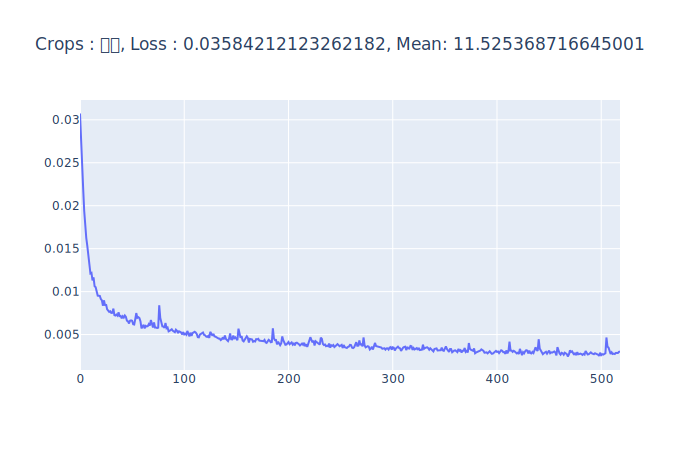

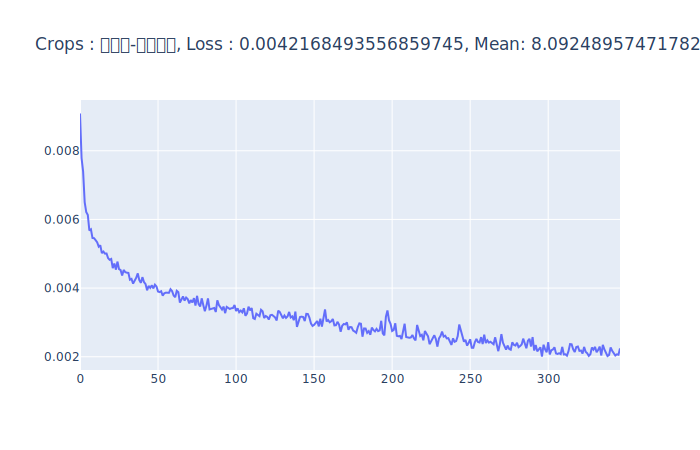

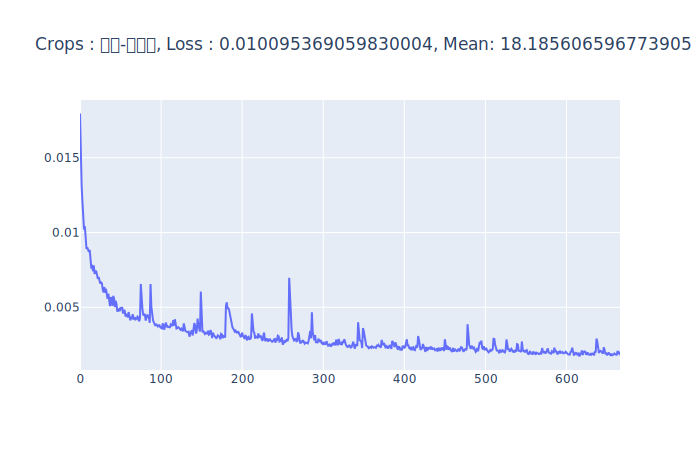

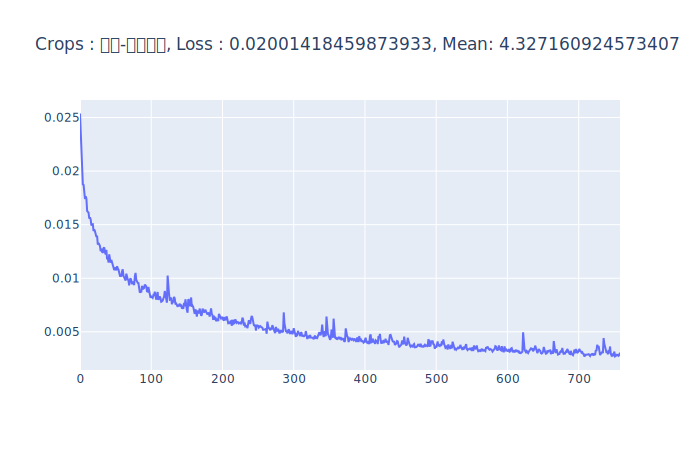

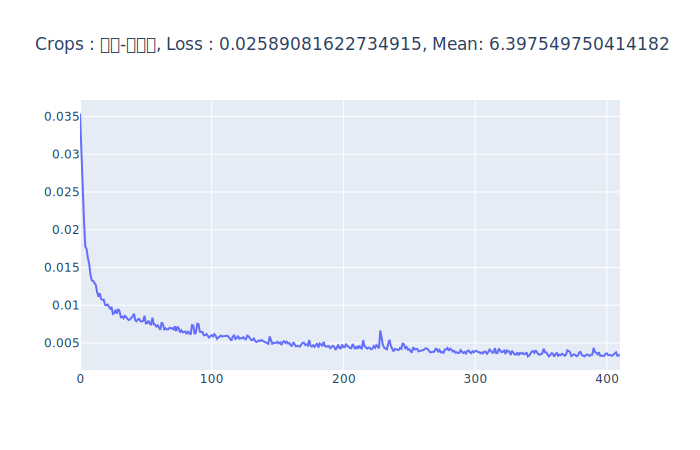

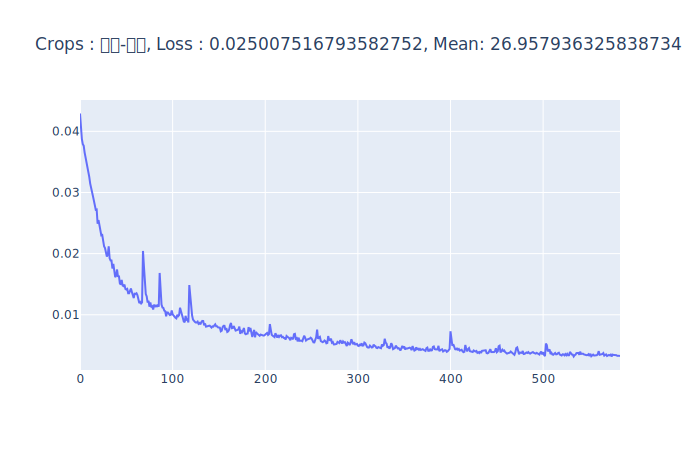

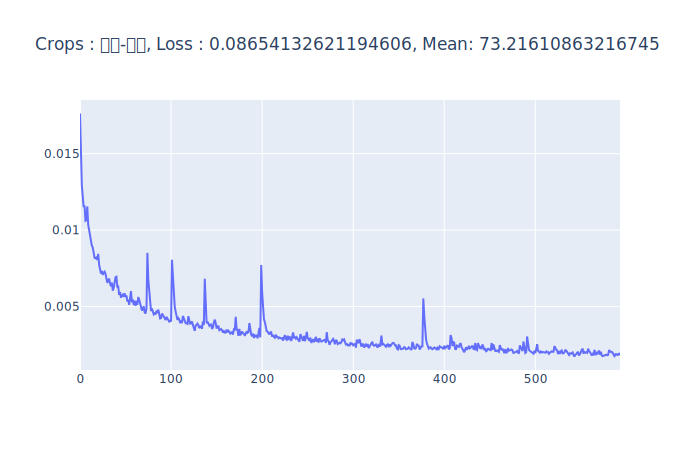

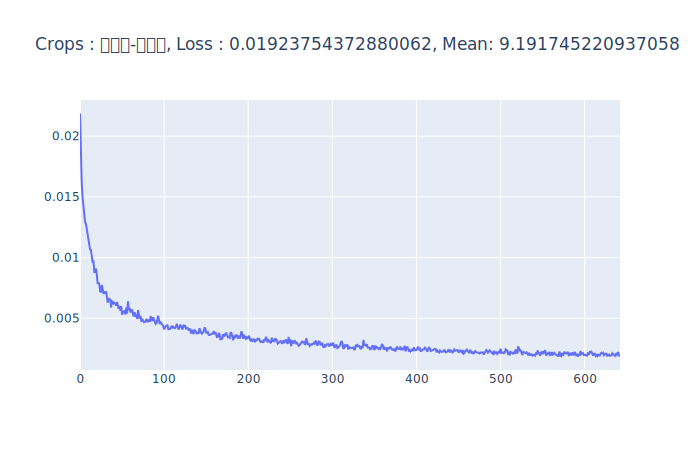

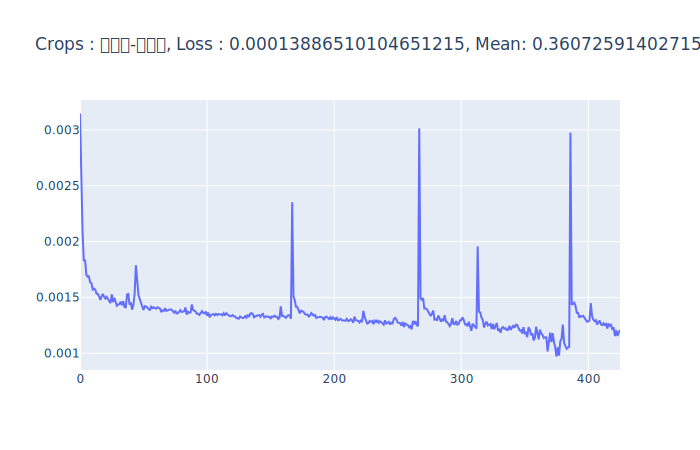

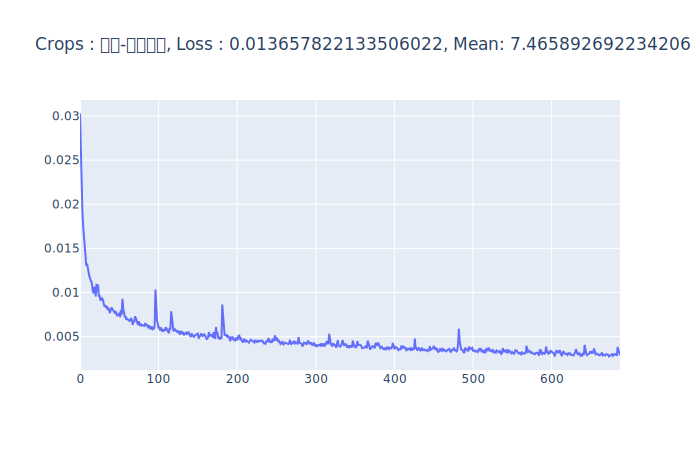

In [3]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    test_y_list, predict_y_list, loss, mean_diff = train(
        df.drop(columns=["DateTime", "Year", "Day"]),
        crops,
        split_boundary - 6,
        "平均價",
    )
    data = {
        "DateTime": df["DateTime"][split_boundary:],
        "Original": test_y_list,
        "Predict": predict_y_list,
        "Loss": loss,
        "Mean": mean_diff
    }
    df = pd.DataFrame(data)
    df.to_csv("{}_Price.csv".format(crops), index=False, encoding="utf_8_sig")

### 1 day return

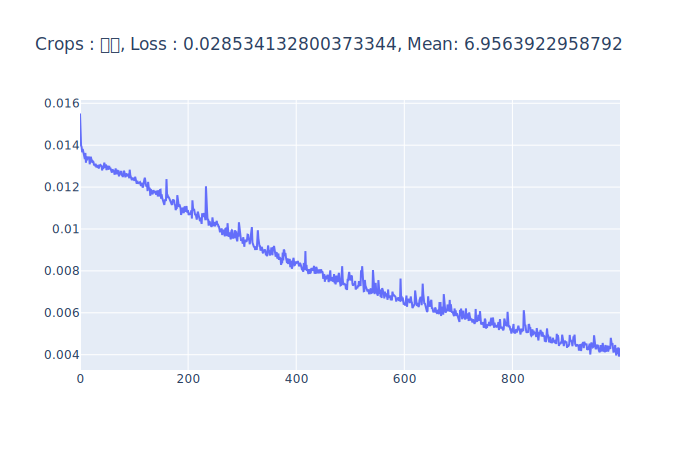

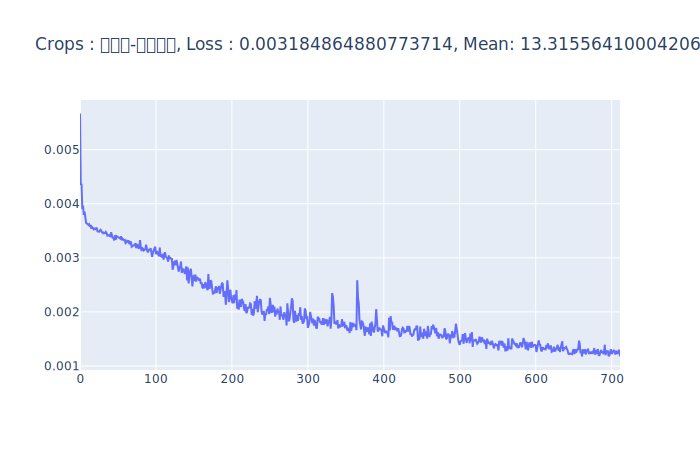

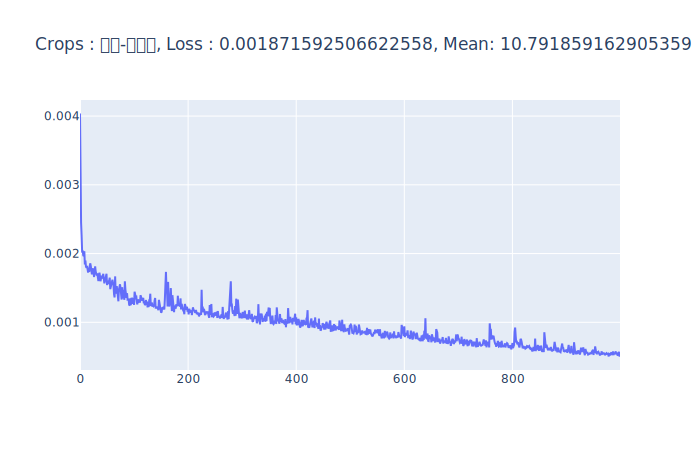

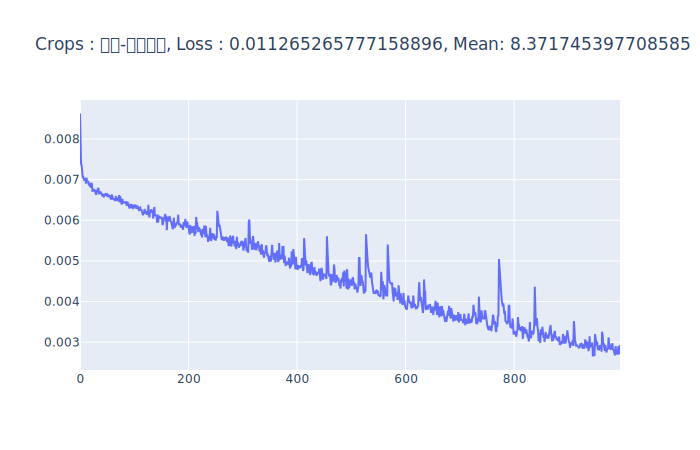

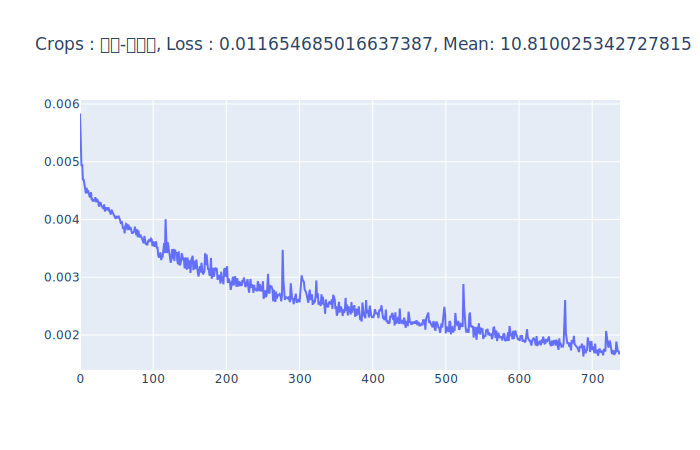

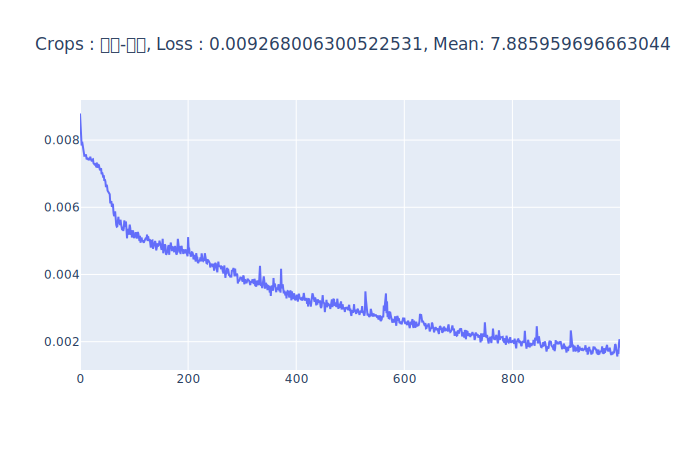

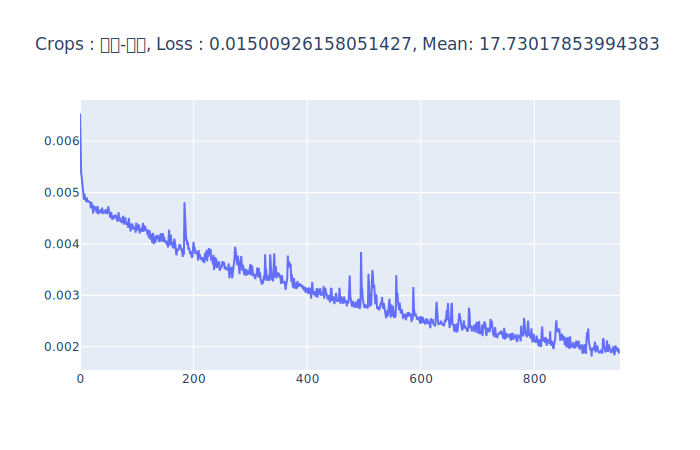

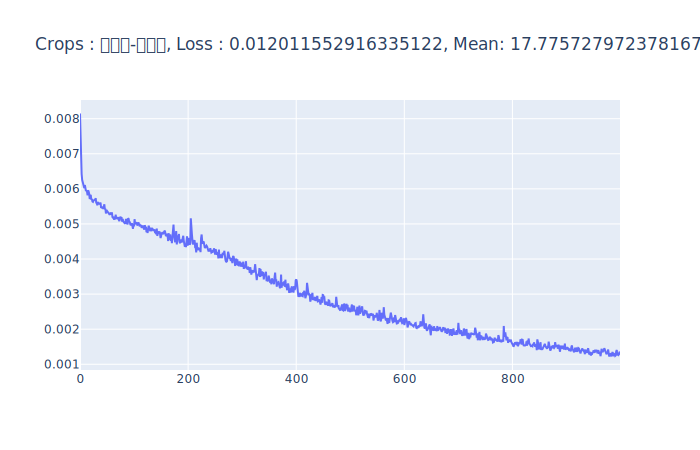

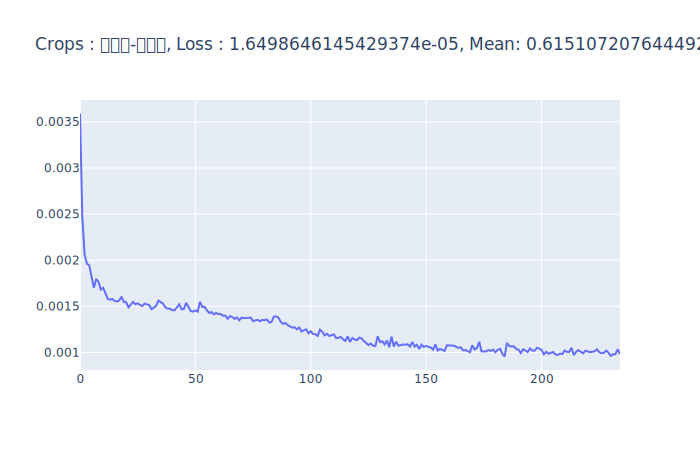

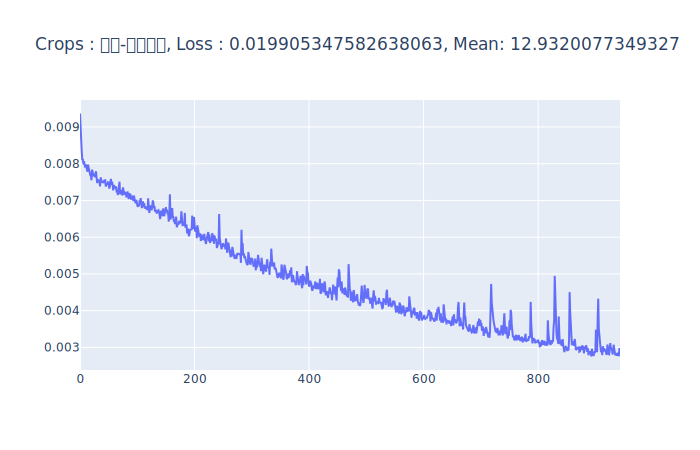

In [4]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    test_y_list, predict_y_list, loss, mean_diff = train(
        df.drop(columns=["DateTime", "Year", "Day"]),
        crops,
        split_boundary - 6,
        "1_day_return",
    )
    data = {
        "DateTime": df["DateTime"][split_boundary:],
        "Original": test_y_list,
        "Predict": predict_y_list,
        "Loss": loss,
        "Mean": mean_diff
    }
    df = pd.DataFrame(data)
    df.to_csv("{}_1_day_return.csv".format(crops), index=False, encoding="utf_8_sig")

### 3 days return

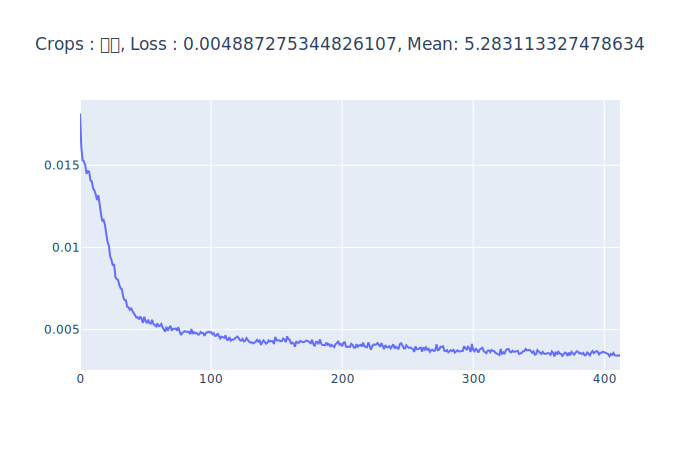

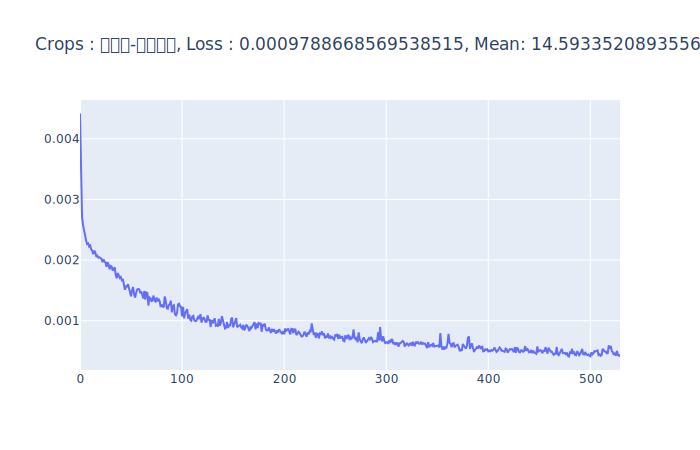

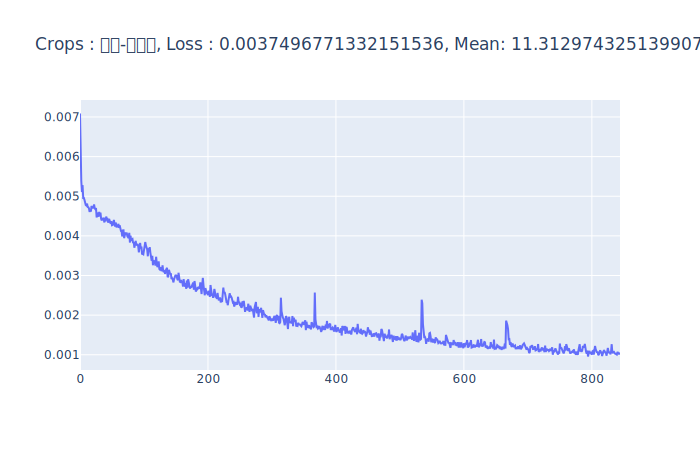

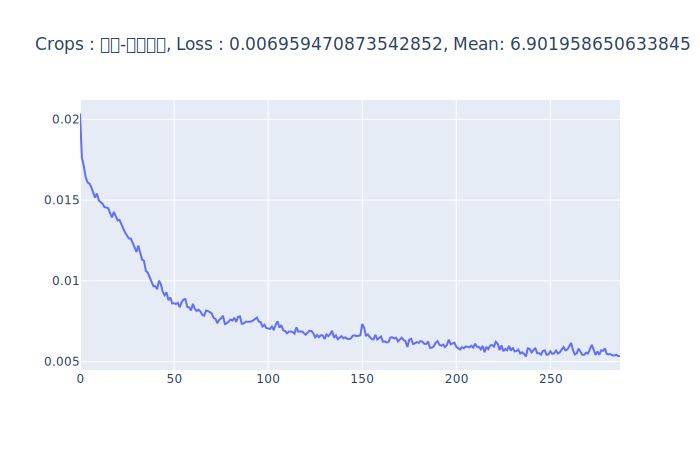

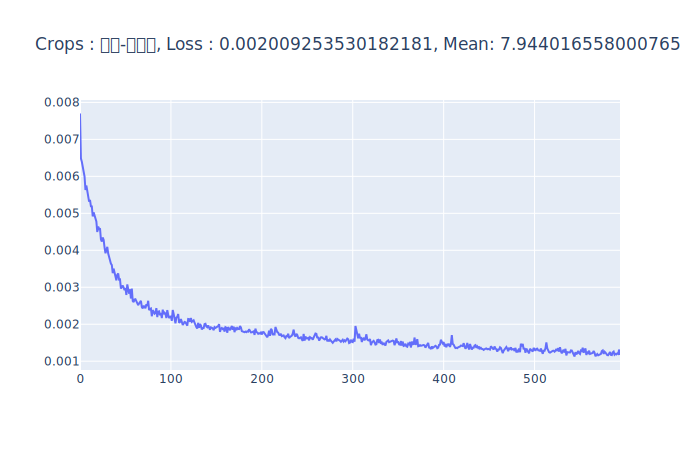

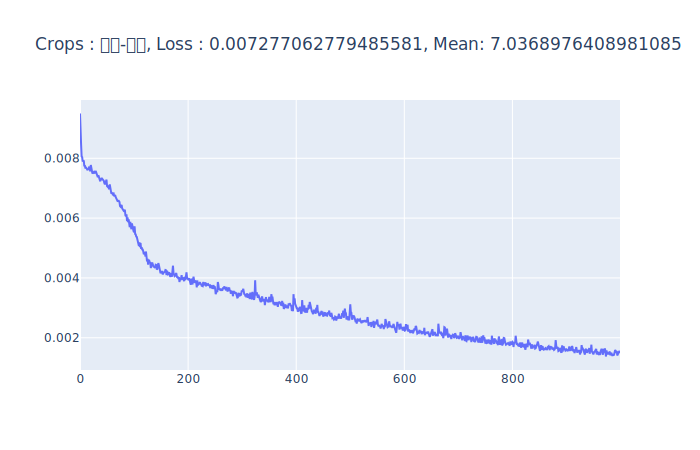

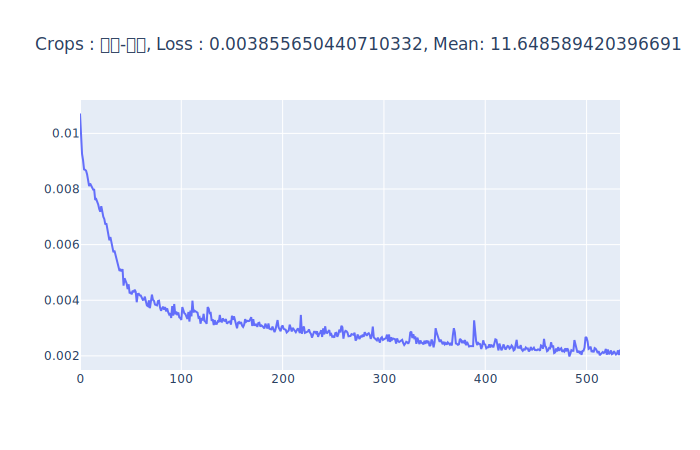

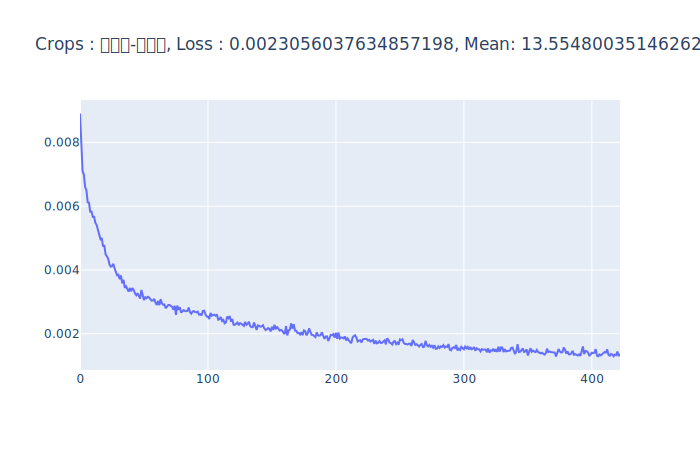

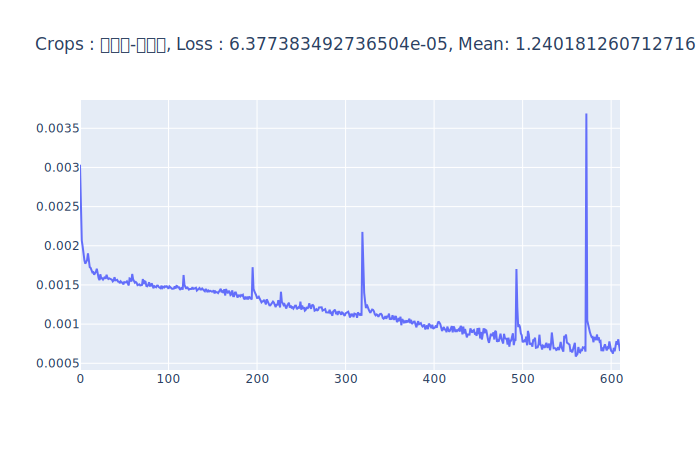

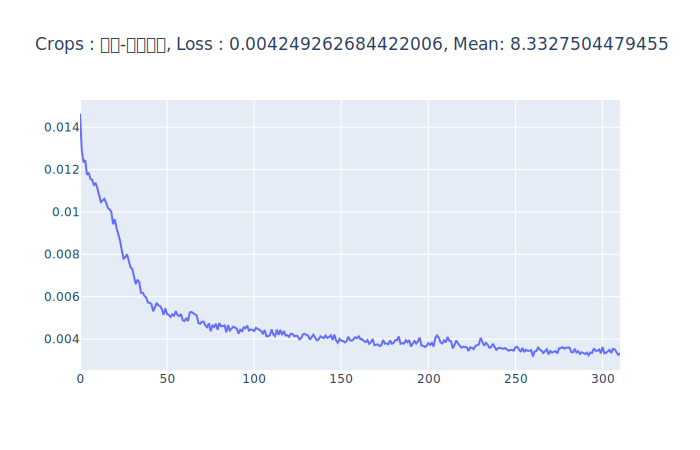

In [5]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    test_y_list, predict_y_list, loss, mean_diff = train(
        df.drop(columns=["DateTime", "Year", "Day"]),
        crops,
        split_boundary - 6,
        "3_day_return",
    )
    data = {
        "DateTime": df["DateTime"][split_boundary:],
        "Original": test_y_list,
        "Predict": predict_y_list,
        "Loss": loss,
        "Mean": mean_diff
    }
    df = pd.DataFrame(data)
    df.to_csv("{}_3_day_return.csv".format(crops), index=False, encoding="utf_8_sig")

## Predict with feature selection
### select top 10 features of each input ( total 7 days input ) and np.unique

In [6]:
import shap

shap.initjs()

def get_important_feature(df, split_boundary, predict_target="3_day_return"):
    norm_df = normalize(df)
    X, Y = train_(norm_df, 5, 1, predict_target)
    train_x, test_x, train_y, test_y = get_train_test(X, Y, split_boundary)

    model = get_model(train_x)
    explainer = shap.GradientExplainer(model, train_x)
    shap_values = explainer.shap_values(test_x)

    feature_index_arr = []

    for i in range(5):
        feature_index_arr.append(
            np.flip(np.argsort(np.abs(shap_values[0]).mean(0))[i])[0:20]
        )
    feature_index = np.unique(feature_index_arr)
    
    # check predict_target in df
    if list(df.columns).index(predict_target) not in feature_index:
        feature_index = np.concatenate([[list(df.columns).index(predict_target)], feature_index])

    return df.iloc[:, feature_index]


### Price


feature selection : Index(['Month', '平均價', '1_day_return', '5_day_return', 'C0A530_StnPres',
       '467490_WS', '467440_StnPres', 'C0C590_WS', 'C0D560_StnPres',
       'C0D560_WS', 'C0E750_StnPres', 'C0E750_Temperature', 'C0H950_Precp',
       'C0G660_StnPres', 'C0G660_Temperature', 'C0G660_Precp',
       'C0K240_StnPres', 'C0K240_Precp', '467480_StnPres', '467480_Precp',
       '467590_StnPres', '467590_Temperature', '467590_Precp', '467080_WS',
       'C0Z061_Temperature', '467660_StnPres'],
      dtype='object')


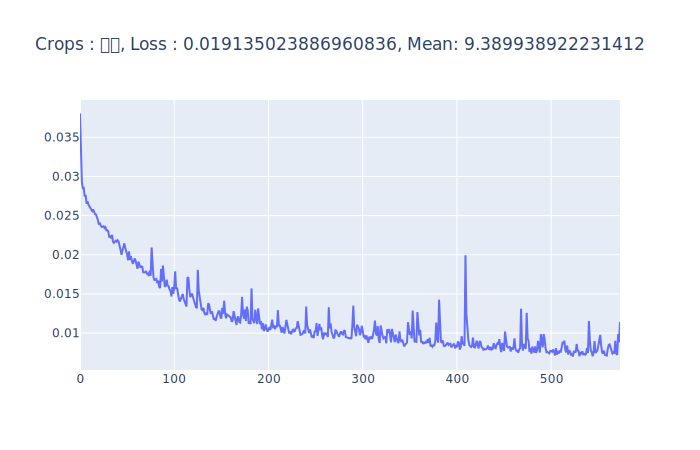

feature selection : Index(['平均價', 'Month', '5_day_return', 'C0A530_StnPres', '467420_WS',
       '467440_StnPres', 'C0C590_StnPres', 'C0C590_Precp', 'C0D560_StnPres',
       'C0E750_StnPres', 'C0E750_Temperature', 'C0H950_Precp',
       'C0G660_StnPres', 'C0G660_Temperature', 'C0K240_Temperature',
       '467480_StnPres', '467590_StnPres', '467590_Temperature',
       '467590_Precp', '467080_StnPres', 'C0Z061_StnPres', 'C0Z061_Precp',
       '467660_StnPres', '467660_Temperature'],
      dtype='object')


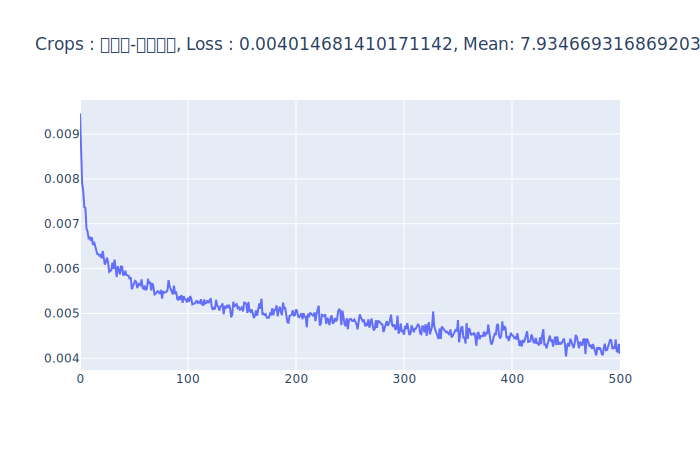

feature selection : Index(['平均價', 'Month', 'C0A530_StnPres', 'C0A530_Precp', '467490_StnPres',
       '467420_StnPres', '467420_WS', '467420_Precp', '467440_StnPres',
       'C0C590_StnPres', 'C0C590_Temperature', 'C0C590_Precp',
       'C0D560_StnPres', 'C0D560_WS', 'C0E750_StnPres', 'C0E750_Temperature',
       'C0H950_StnPres', 'C0G660_StnPres', 'C0G660_WS', 'C0G660_Precp',
       'C0K240_Precp', '467480_Precp', '467590_StnPres', '467590_Precp',
       'C0Z061_StnPres', 'C0Z061_Precp', '467660_StnPres'],
      dtype='object')


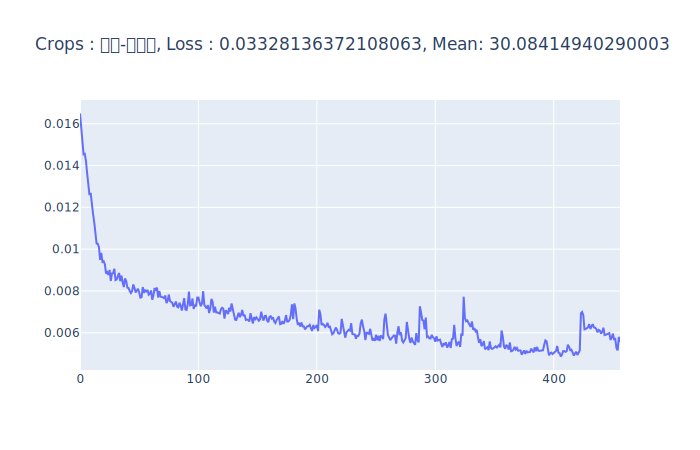

feature selection : Index(['平均價', 'Month', '5_day_return', 'C0A530_WS', 'C0A530_Precp',
       '467420_StnPres', '467420_Precp', '467440_StnPres', 'C0C590_StnPres',
       'C0C590_Precp', 'C0D560_StnPres', 'C0E750_StnPres',
       'C0E750_Temperature', 'C0H950_Precp', 'C0G660_StnPres',
       'C0G660_Temperature', 'C0G660_WS', 'C0K240_WS', '467480_StnPres',
       '467480_Precp', '467590_StnPres', '467590_Temperature', '467590_WS',
       '467590_Precp', '467080_StnPres', 'C0Z061_StnPres',
       'C0Z061_Temperature', '467660_StnPres'],
      dtype='object')


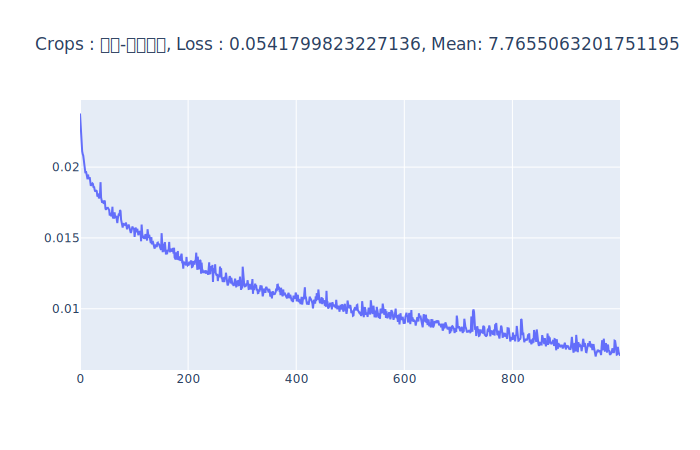

feature selection : Index(['平均價', 'Month', 'C0A530_StnPres', 'C0A530_WS', '467490_StnPres',
       '467420_Precp', 'C0C590_Precp', 'C0D560_StnPres', 'C0D560_WS',
       'C0D560_Precp', 'C0E750_StnPres', 'C0E750_Precp', 'C0H950_Precp',
       'C0G660_Temperature', 'C0G660_WS', 'C0G660_Precp', 'C0K240_Precp',
       '467480_StnPres', '467480_Temperature', '467480_WS', '467480_Precp',
       '467590_StnPres', 'C0Z061_Precp', '467660_StnPres',
       '467660_Temperature'],
      dtype='object')


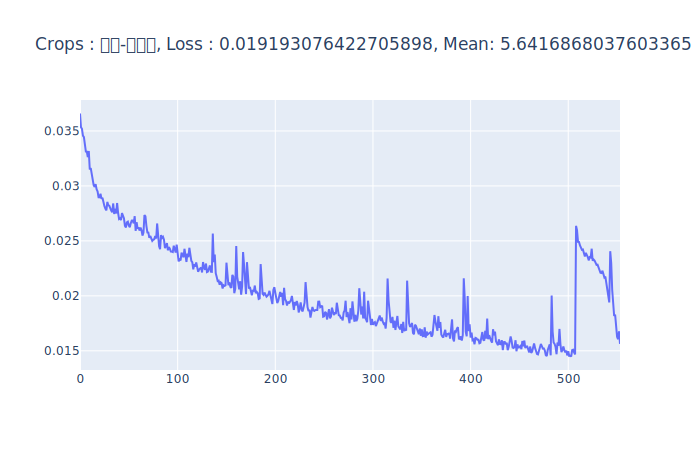

feature selection : Index(['平均價', 'Month', '1_day_return', '3_day_return', '5_day_return',
       'C0A530_StnPres', 'C0A530_WS', 'C0A530_Precp', '467490_StnPres',
       '467490_Temperature', 'C0C590_Temperature', 'C0C590_Precp',
       'C0E750_StnPres', 'C0E750_Temperature', 'C0E750_Precp',
       'C0H950_StnPres', 'C0G660_StnPres', 'C0G660_Temperature', 'C0G660_WS',
       'C0G660_Precp', 'C0K240_StnPres', '467480_StnPres',
       '467480_Temperature', '467480_Precp', '467590_Precp', '467080_StnPres',
       'C0Z061_Temperature'],
      dtype='object')


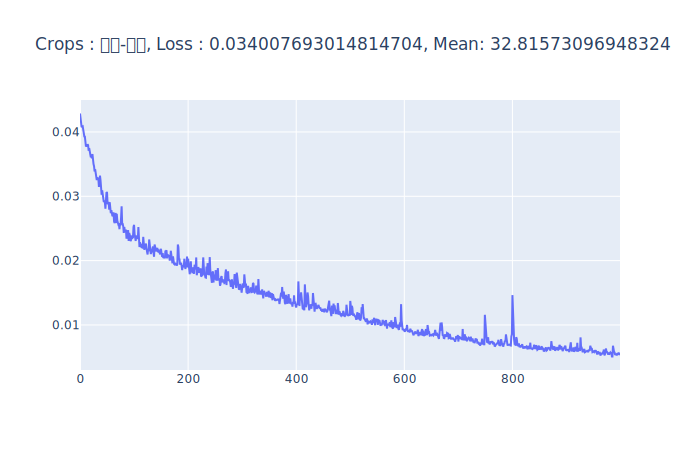

feature selection : Index(['平均價', '1_day_return', '3_day_return', 'C0A530_StnPres', 'C0A530_Precp',
       '467490_StnPres', '467420_StnPres', 'C0D560_WS', 'C0E750_StnPres',
       'C0E750_Temperature', 'C0E750_WS', 'C0E750_Precp', 'C0G660_StnPres',
       'C0G660_Temperature', 'C0G660_WS', 'C0K240_StnPres',
       'C0K240_Temperature', '467480_StnPres', '467480_WS', '467480_Precp',
       '467590_Temperature', '467080_StnPres', 'C0Z061_StnPres',
       'C0Z061_Precp', '467660_StnPres'],
      dtype='object')


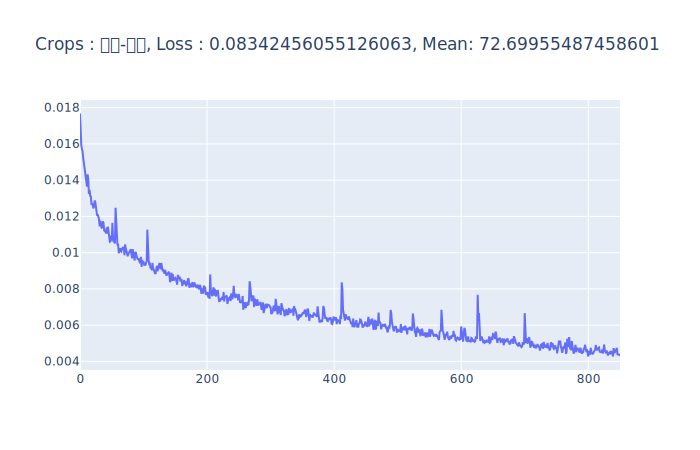

feature selection : Index(['平均價', 'Month', '3_day_return', '5_day_return', 'C0A530_StnPres',
       '467490_Temperature', '467420_Precp', '467440_StnPres',
       'C0C590_Temperature', 'C0D560_WS', 'C0E750_Temperature',
       'C0H950_StnPres', 'C0H950_Precp', 'C0G660_StnPres',
       'C0G660_Temperature', 'C0G660_WS', 'C0G660_Precp', 'C0K240_Precp',
       '467480_Temperature', '467590_StnPres', '467590_Temperature',
       '467590_Precp', 'C0Z061_WS', '467660_StnPres'],
      dtype='object')


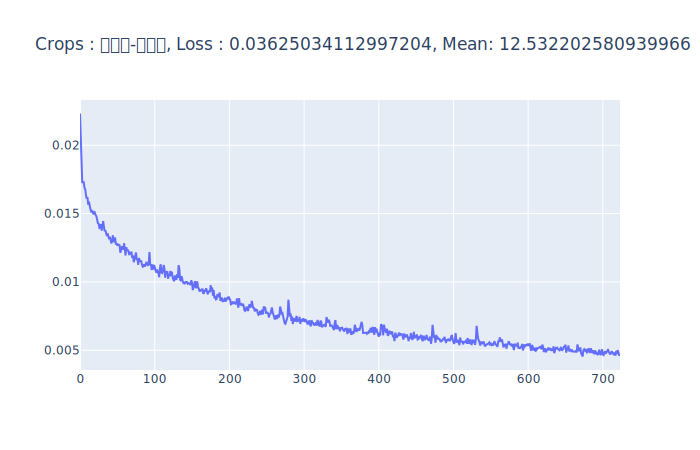

feature selection : Index(['平均價', 'Month', 'C0A530_StnPres', 'C0A530_WS', 'C0A530_Precp',
       '467490_StnPres', '467490_Temperature', '467420_Precp',
       'C0C590_StnPres', 'C0C590_Temperature', 'C0C590_Precp',
       'C0E750_StnPres', 'C0E750_Temperature', 'C0H950_StnPres',
       'C0G660_StnPres', 'C0G660_Temperature', 'C0G660_WS', 'C0G660_Precp',
       '467480_Temperature', '467480_Precp', '467080_StnPres',
       'C0Z061_StnPres', 'C0Z061_Temperature', 'C0Z061_Precp',
       '467660_StnPres'],
      dtype='object')


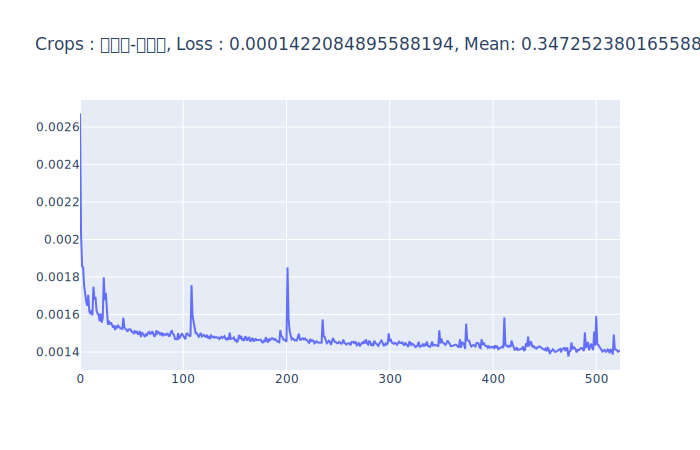

feature selection : Index(['平均價', 'Month', 'C0A530_StnPres', 'C0A530_WS', '467420_Precp',
       '467440_StnPres', 'C0C590_StnPres', 'C0C590_Precp', 'C0D560_StnPres',
       'C0D560_Temperature', 'C0D560_WS', 'C0E750_StnPres',
       'C0E750_Temperature', 'C0E750_Precp', 'C0H950_Precp', 'C0G660_StnPres',
       'C0G660_Temperature', 'C0G660_WS', 'C0G660_Precp', 'C0K240_StnPres',
       'C0K240_Temperature', '467480_StnPres', '467480_Temperature',
       '467480_Precp', '467590_Temperature', '467590_Precp', '467080_StnPres',
       'C0Z061_StnPres', 'C0Z061_Precp', '467660_StnPres', '467660_WS'],
      dtype='object')


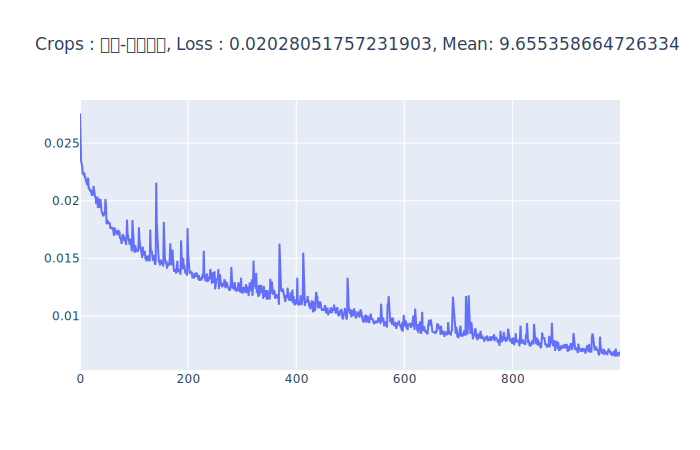

In [7]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    DateTime_arr = df["DateTime"][split_boundary:]
    df = df.drop(columns=["DateTime", "Year", "Day"])
    df = get_important_feature(df, split_boundary - 6, "平均價")
    print("feature selection :", df.columns)
    test_y_list, predict_y_list, loss, mean_diff = train(df, crops, split_boundary - 6, "平均價")
    data = {
        "DateTime": DateTime_arr,
        "Original": test_y_list,
        "Predict": predict_y_list,
        "Loss": loss,
        "Mean": mean_diff
    }
    df = pd.DataFrame(data)
    df.to_csv("{}_Price_fs.csv".format(crops), index=False, encoding="utf_8_sig")

### 1 day return


feature selection : Index(['1_day_return', 'Month', '平均價', '3_day_return', '交易量',
       'C0A530_Temperature', '467420_Precp', '467440_StnPres', 'C0C590_Precp',
       'C0D560_StnPres', 'C0D560_Temperature', 'C0E750_StnPres',
       'C0H950_Temperature', 'C0G660_StnPres', 'C0G660_Temperature',
       'C0G660_Precp', 'C0K240_Temperature', 'C0K240_Precp', '467480_StnPres',
       '467480_Precp', '467590_StnPres', '467590_Temperature', '467590_WS',
       '467080_StnPres', 'C0Z061_StnPres', '467660_StnPres'],
      dtype='object')


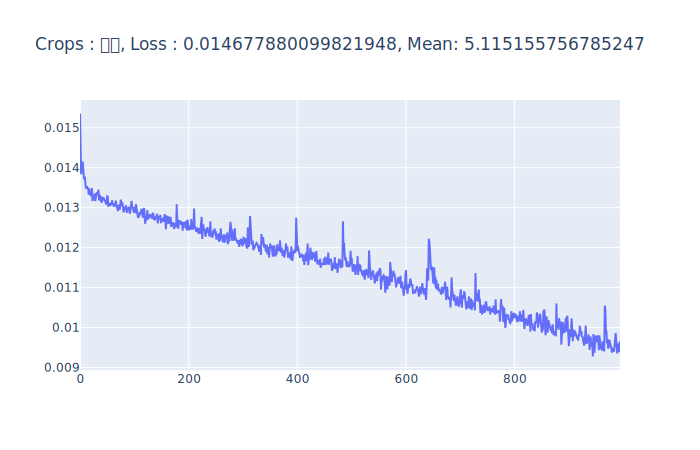

feature selection : Index(['1_day_return', 'Month', '平均價', '強度', 'C0A530_StnPres',
       'C0A530_Temperature', 'C0A530_Precp', '467490_StnPres',
       '467490_Temperature', '467440_StnPres', '467440_Temperature',
       'C0C590_StnPres', 'C0C590_WS', 'C0D560_Temperature', 'C0D560_WS',
       'C0E750_StnPres', 'C0E750_Precp', 'C0H950_StnPres', 'C0H950_Precp',
       'C0G660_Temperature', 'C0G660_WS', 'C0G660_Precp', 'C0K240_Temperature',
       '467480_StnPres', '467480_Precp', '467590_WS', '467080_StnPres',
       'C0Z061_StnPres', 'C0Z061_Temperature'],
      dtype='object')


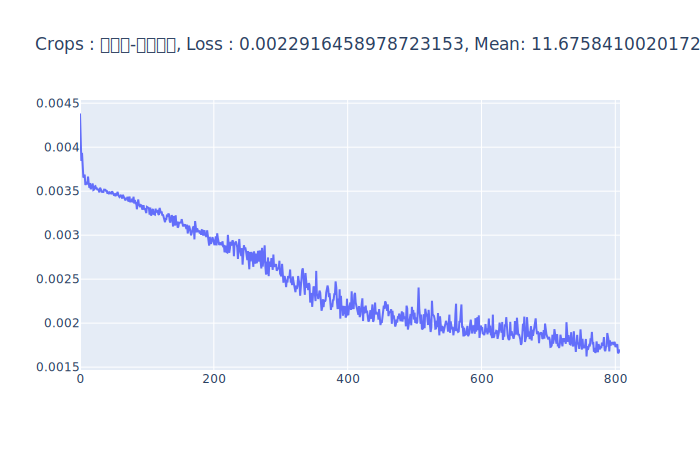

feature selection : Index(['1_day_return', 'Month', '平均價', '5_day_return', 'C0A530_StnPres',
       '467490_StnPres', '467420_Precp', '467440_StnPres', 'C0C590_StnPres',
       'C0C590_Temperature', 'C0D560_StnPres', 'C0E750_Temperature',
       'C0G660_Temperature', 'C0G660_Precp', 'C0K240_StnPres',
       'C0K240_Temperature', 'C0K240_Precp', '467480_StnPres',
       '467590_StnPres', '467590_Temperature', '467590_WS', '467080_StnPres',
       'C0Z061_StnPres', 'C0Z061_Temperature', 'C0Z061_Precp',
       '467660_StnPres'],
      dtype='object')


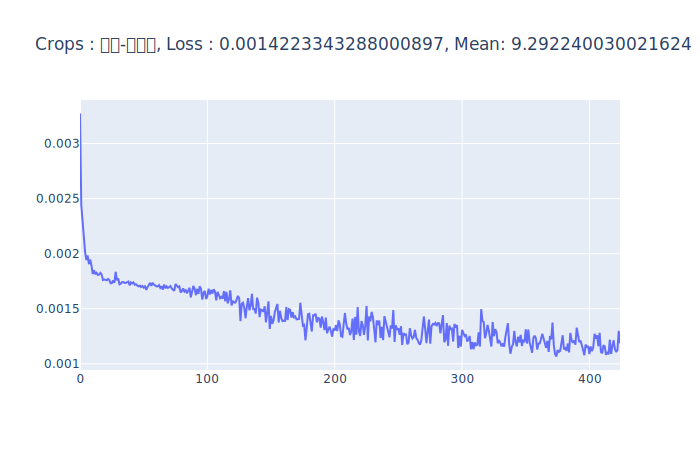

feature selection : Index(['1_day_return', '3_day_return', 'C0A530_StnPres', '467490_StnPres',
       '467490_Temperature', '467490_WS', '467420_StnPres', '467420_Precp',
       '467440_StnPres', 'C0C590_StnPres', 'C0C590_Precp', 'C0D560_StnPres',
       'C0D560_WS', 'C0E750_StnPres', 'C0E750_Temperature',
       'C0G660_Temperature', 'C0K240_StnPres', '467480_StnPres',
       '467480_Precp', '467590_Temperature', '467590_WS', '467590_Precp',
       '467080_StnPres', '467080_WSGust', 'C0Z061_Temperature'],
      dtype='object')


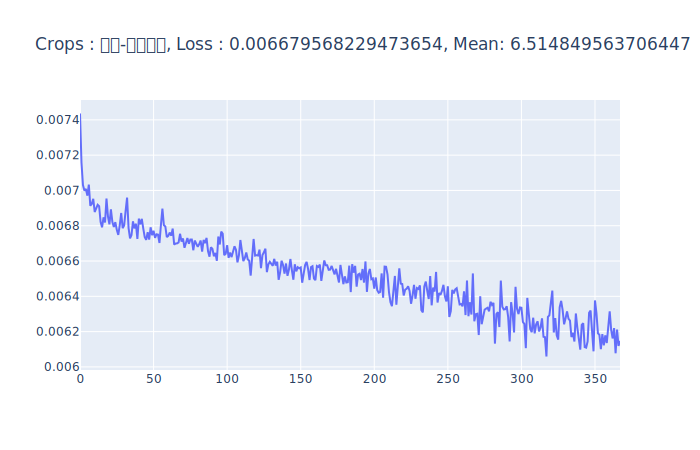

feature selection : Index(['1_day_return', 'C0A530_StnPres', 'C0A530_WS', '467490_StnPres',
       '467420_StnPres', '467420_WS', '467420_Precp', '467440_Temperature',
       'C0C590_StnPres', 'C0C590_Temperature', 'C0D560_StnPres', 'C0D560_WS',
       'C0E750_StnPres', 'C0E750_Temperature', 'C0G660_Temperature',
       'C0K240_StnPres', '467480_StnPres', '467480_Temperature', '467480_WS',
       '467480_Precp', '467590_StnPres', '467590_Temperature', '467590_WS',
       '467590_Precp', 'C0Z061_StnPres', 'C0Z061_Precp', '467660_StnPres'],
      dtype='object')


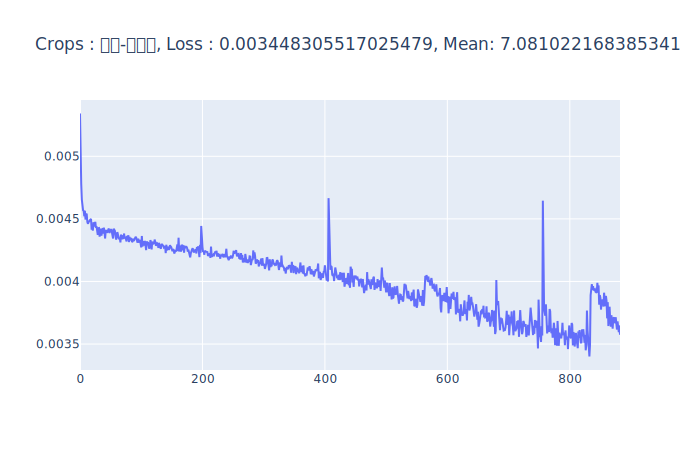

feature selection : Index(['1_day_return', 'Month', 'C0A530_StnPres', 'C0A530_Temperature',
       'C0A530_WS', '467420_StnPres', '467420_Precp', '467440_StnPres',
       'C0C590_Temperature', 'C0C590_WS', 'C0D560_StnPres', 'C0D560_Precp',
       'C0E750_StnPres', 'C0E750_Temperature', 'C0H950_StnPres',
       'C0H950_Precp', 'C0G660_StnPres', 'C0G660_Temperature',
       'C0K240_StnPres', 'C0K240_Temperature', '467480_Temperature',
       '467590_Temperature', '467590_Precp', '467080_StnPres',
       'C0Z061_StnPres', '467660_StnPres', '467660_Temperature'],
      dtype='object')


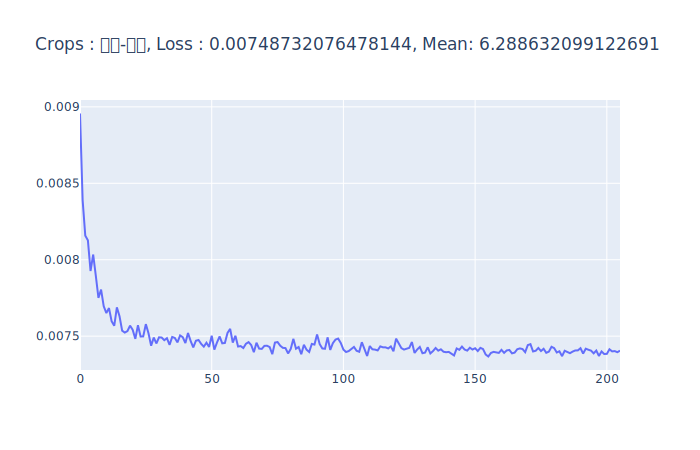

feature selection : Index(['1_day_return', 'Month', '平均價', '強度', '467420_Precp', '467440_StnPres',
       'C0C590_StnPres', 'C0C590_WS', 'C0C590_Precp', 'C0D560_StnPres',
       'C0D560_Temperature', 'C0D560_WS', 'C0D560_Precp', 'C0E750_StnPres',
       'C0H950_StnPres', 'C0G660_StnPres', 'C0G660_Temperature', 'C0G660_WS',
       'C0K240_StnPres', 'C0K240_Temperature', 'C0K240_Precp',
       '467590_StnPres', '467590_WS', '467590_Precp', 'C0Z061_Precp',
       '467660_StnPres'],
      dtype='object')


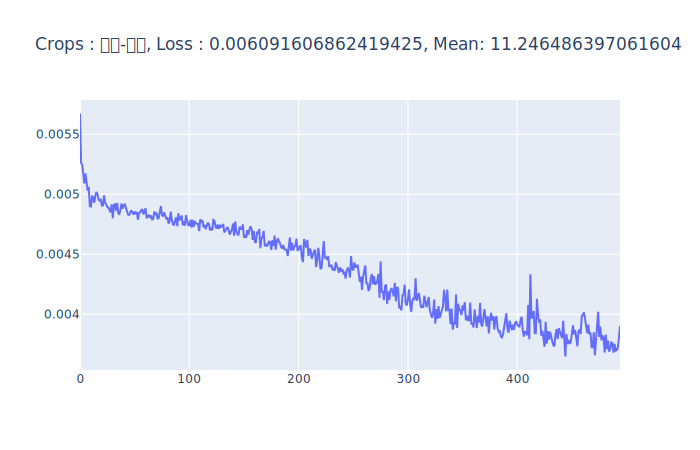

feature selection : Index(['1_day_return', 'Month', '平均價', '5_day_return', 'C0A530_Temperature',
       'C0A530_WS', '467490_StnPres', '467490_Temperature', '467420_Precp',
       '467440_StnPres', 'C0C590_StnPres', 'C0C590_Temperature',
       'C0D560_StnPres', 'C0D560_Temperature', 'C0D560_Precp',
       'C0E750_StnPres', 'C0E750_Precp', 'C0G660_StnPres',
       'C0G660_Temperature', 'C0K240_Temperature', '467590_WS', '467590_Precp',
       '467080_StnPres', 'C0Z061_StnPres', 'C0Z061_Precp', '467660_StnPres'],
      dtype='object')


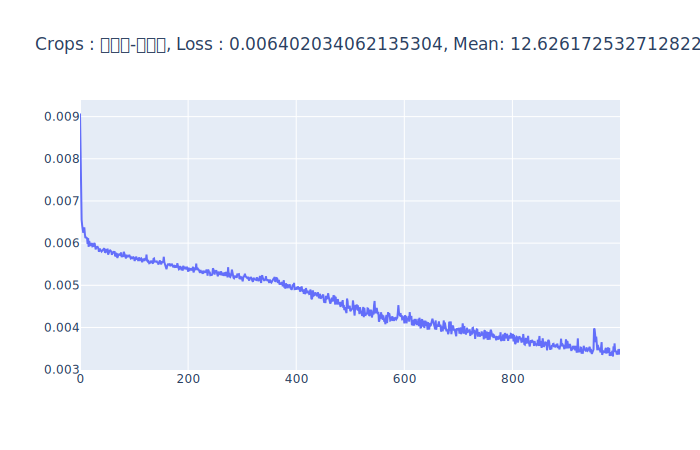

feature selection : Index(['1_day_return', 'Month', 'C0A530_Temperature', 'C0A530_Precp',
       '467490_StnPres', '467490_Temperature', '467420_Precp',
       '467440_StnPres', 'C0C590_StnPres', 'C0C590_Temperature',
       'C0D560_StnPres', 'C0E750_StnPres', 'C0E750_Temperature',
       'C0H950_Precp', 'C0G660_StnPres', 'C0G660_Temperature', 'C0G660_WS',
       'C0K240_Temperature', '467480_StnPres', '467480_Temperature',
       '467480_Precp', '467590_StnPres', '467590_Temperature', '467590_WS',
       '467590_Precp', '467080_StnPres', '467080_Precp', 'C0Z061_StnPres',
       'C0Z061_Temperature', 'C0Z061_Precp', '467660_StnPres'],
      dtype='object')


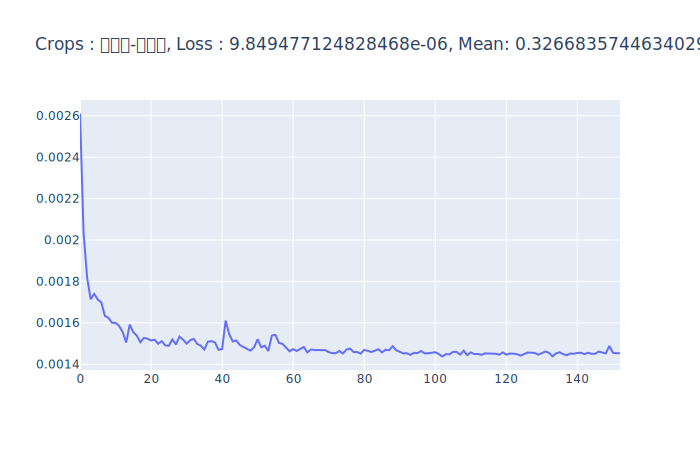

feature selection : Index(['1_day_return', 'Month', '5_day_return', 'C0A530_StnPres',
       '467490_StnPres', '467420_StnPres', '467420_WS', '467420_Precp',
       'C0C590_StnPres', 'C0C590_Temperature', 'C0C590_WS', 'C0D560_StnPres',
       'C0D560_Temperature', 'C0E750_StnPres', 'C0E750_Precp',
       'C0H950_StnPres', 'C0G660_Temperature', 'C0G660_Precp', 'C0K240_Precp',
       '467480_Precp', '467590_StnPres', '467590_Temperature', '467590_WS',
       '467590_Precp', '467080_StnPres', 'C0Z061_StnPres', '467660_StnPres'],
      dtype='object')


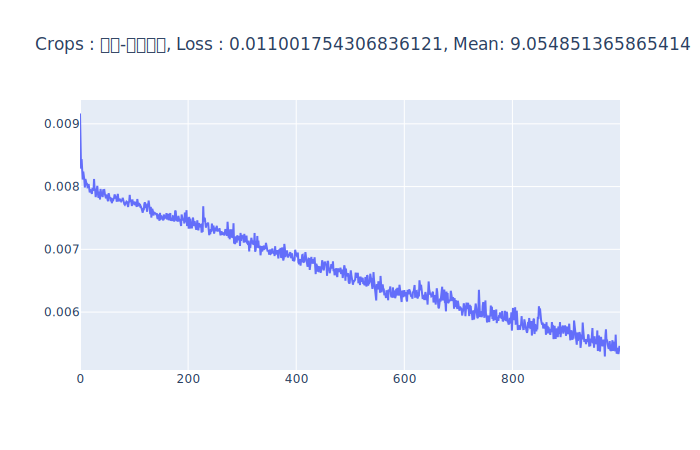

In [8]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    DateTime_arr = df["DateTime"][split_boundary:]
    df = df.drop(columns=["DateTime", "Year", "Day"])
    df = get_important_feature(df, split_boundary - 6, "1_day_return")
    print("feature selection :", df.columns)
    test_y_list, predict_y_list, loss, mean_diff = train(df, crops, split_boundary - 6, "1_day_return")
    data = {
        "DateTime": DateTime_arr,
        "Original": test_y_list,
        "Predict": predict_y_list,
        "Loss": loss,
        "Mean": mean_diff
    }
    df = pd.DataFrame(data)
    df.to_csv("{}_1_day_return_fs.csv".format(crops), index=False, encoding="utf_8_sig")

### 3 days return

feature selection : Index(['3_day_return', 'Month', '5_day_return', '交易量', 'C0A530_StnPres',
       'C0A530_WS', 'C0A530_Precp', '467420_StnPres', '467440_Temperature',
       'C0C590_StnPres', 'C0C590_Temperature', 'C0C590_WS', 'C0C590_Precp',
       'C0D560_StnPres', 'C0D560_Precp', 'C0E750_Temperature',
       'C0H950_StnPres', 'C0H950_Precp', 'C0G660_StnPres',
       'C0G660_Temperature', 'C0G660_Precp', 'C0K240_Temperature',
       'C0K240_Precp', '467480_StnPres', '467480_Temperature', '467590_Precp',
       '467080_StnPres', 'C0Z061_StnPres', 'C0Z061_Temperature'],
      dtype='object')


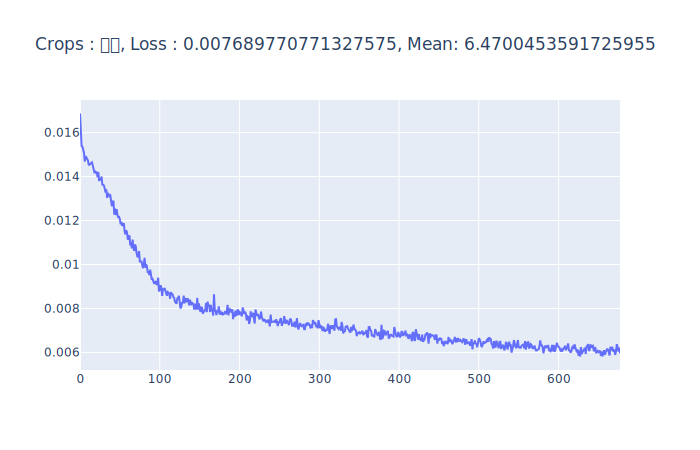

feature selection : Index(['3_day_return', 'Month', 'C0A530_StnPres', 'C0A530_Temperature',
       '467490_Temperature', '467420_StnPres', '467420_WS', '467420_Precp',
       'C0C590_StnPres', 'C0C590_Temperature', 'C0C590_WS', 'C0D560_Precp',
       'C0E750_StnPres', 'C0E750_Temperature', 'C0G660_Temperature',
       'C0G660_WS', 'C0K240_Temperature', '467480_StnPres',
       '467480_Temperature', '467480_Precp', '467590_Temperature', '467590_WS',
       '467080_StnPres', 'C0Z061_StnPres', 'C0Z061_Temperature',
       '467660_StnPres'],
      dtype='object')


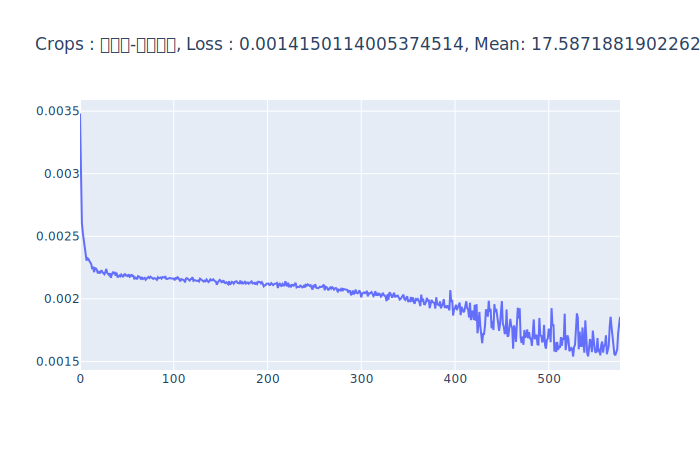

feature selection : Index(['3_day_return', 'Month', '5_day_return', 'C0A530_StnPres',
       'C0A530_Precp', '467490_StnPres', '467490_Temperature',
       '467420_StnPres', '467420_Precp', '467440_StnPres', 'C0C590_StnPres',
       'C0D560_StnPres', 'C0D560_Temperature', 'C0D560_WS', 'C0D560_Precp',
       'C0E750_StnPres', 'C0E750_Temperature', 'C0E750_Precp',
       'C0H950_StnPres', 'C0H950_Precp', 'C0G660_WS', 'C0K240_Precp',
       '467480_StnPres', '467480_Precp', '467590_StnPres', '467590_WS',
       '467590_Precp', '467080_WSGust', 'C0Z061_Precp'],
      dtype='object')


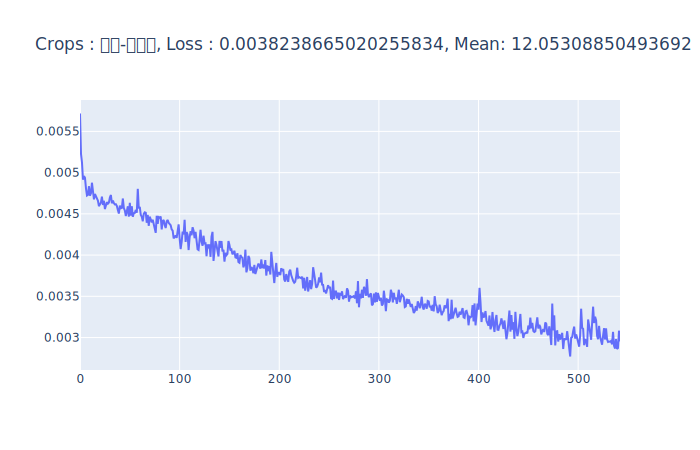

feature selection : Index(['Month', '3_day_return', 'C0A530_StnPres', '467490_StnPres',
       '467490_Temperature', '467440_StnPres', '467440_WS', 'C0C590_StnPres',
       'C0D560_Precp', 'C0E750_StnPres', 'C0E750_Temperature',
       'C0H950_StnPres', 'C0H950_Precp', 'C0G660_Temperature', 'C0G660_WS',
       'C0G660_Precp', 'C0K240_Temperature', 'C0K240_WS', '467480_StnPres',
       '467480_WS', '467480_Precp', '467590_Temperature', '467590_Precp',
       '467080_StnPres', 'C0Z061_StnPres'],
      dtype='object')


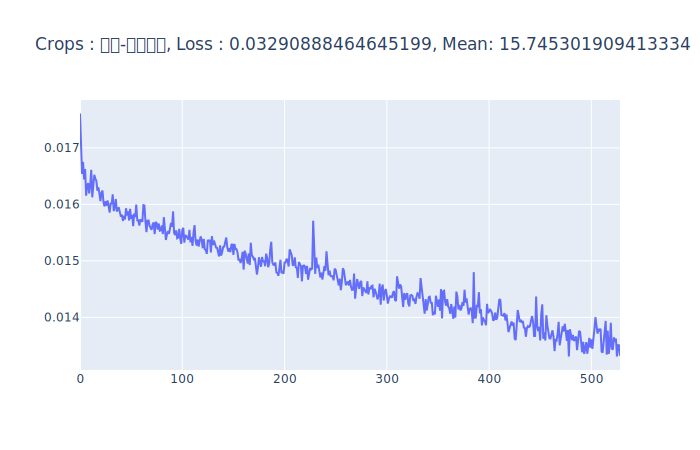

feature selection : Index(['3_day_return', 'Month', '平均價', '5_day_return', '467490_StnPres',
       '467490_Temperature', '467440_StnPres', '467440_Temperature',
       'C0C590_StnPres', 'C0C590_Temperature', 'C0C590_WS', 'C0D560_StnPres',
       'C0D560_Precp', 'C0E750_StnPres', 'C0E750_Precp', 'C0H950_Temperature',
       'C0H950_Precp', 'C0G660_StnPres', 'C0G660_Temperature', 'C0G660_Precp',
       'C0K240_Precp', '467480_Precp', '467590_StnPres', '467590_Temperature',
       '467590_WS', '467080_StnPres', '467660_StnPres'],
      dtype='object')


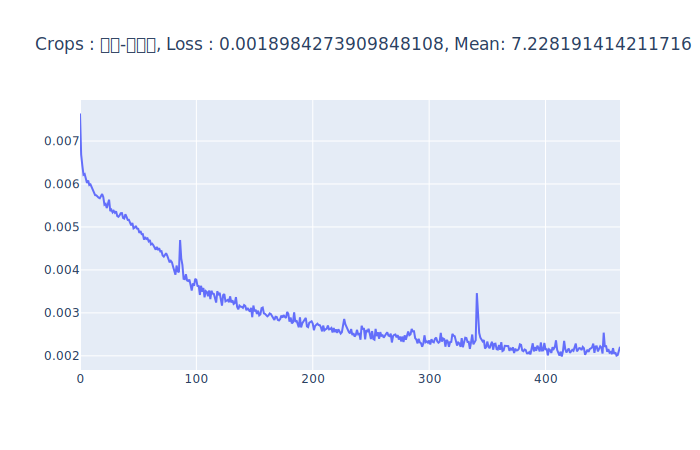

feature selection : Index(['3_day_return', 'Month', '1_day_return', '5_day_return',
       'C0A530_Temperature', '467490_StnPres', '467440_StnPres',
       'C0C590_Temperature', 'C0D560_StnPres', 'C0D560_Precp',
       'C0E750_StnPres', 'C0E750_Temperature', 'C0H950_StnPres',
       'C0G660_StnPres', 'C0G660_Temperature', 'C0G660_Precp',
       'C0K240_StnPres', '467480_StnPres', '467480_Precp', '467590_StnPres',
       '467590_Temperature', '467590_WS', '467590_Precp', 'C0Z061_StnPres',
       'C0Z061_Temperature', '467660_StnPres'],
      dtype='object')


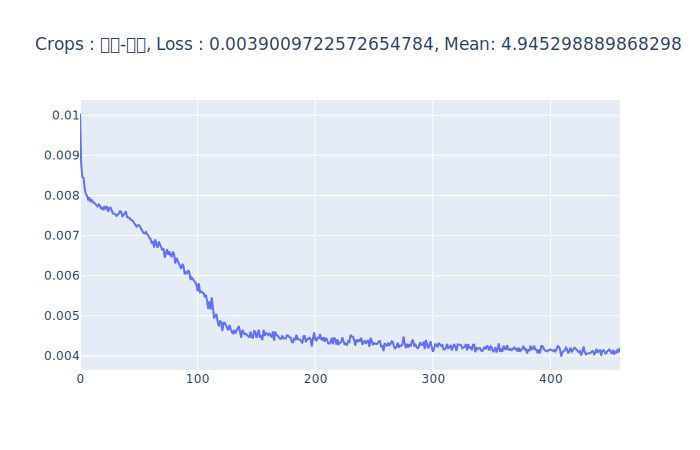

feature selection : Index(['3_day_return', 'Month', '平均價', '5_day_return', 'C0A530_Precp',
       '467490_StnPres', '467420_StnPres', '467420_WS', '467440_StnPres',
       'C0C590_StnPres', 'C0D560_StnPres', 'C0E750_StnPres',
       'C0E750_Temperature', 'C0E750_Precp', 'C0H950_Precp', 'C0G660_StnPres',
       'C0G660_Temperature', 'C0K240_WS', 'C0K240_Precp', '467480_Temperature',
       '467590_Temperature', '467590_WS', '467590_Precp', 'C0Z061_StnPres',
       'C0Z061_Precp', '467660_StnPres'],
      dtype='object')


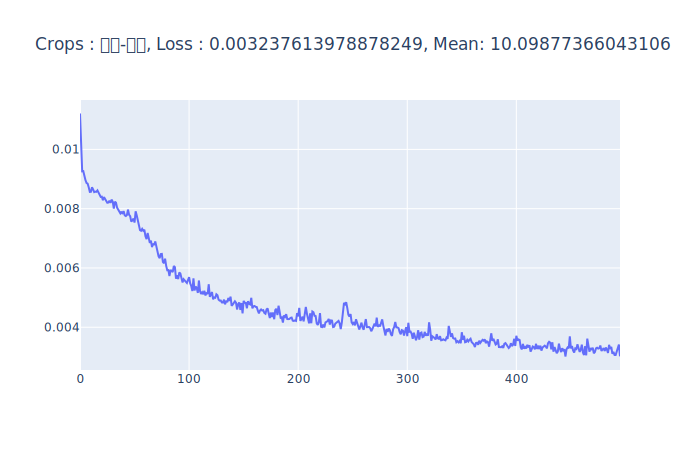

feature selection : Index(['3_day_return', 'Month', '平均價', '5_day_return', '強度', 'C0A530_StnPres',
       '467420_Precp', '467440_StnPres', 'C0C590_WS', 'C0C590_Precp',
       'C0D560_StnPres', 'C0D560_Precp', 'C0E750_StnPres',
       'C0E750_Temperature', 'C0E750_Precp', 'C0H950_StnPres',
       'C0G660_StnPres', 'C0G660_Temperature', '467480_Temperature',
       '467480_Precp', '467590_StnPres', '467590_Temperature',
       '467080_StnPres', 'C0Z061_StnPres', '467660_StnPres'],
      dtype='object')


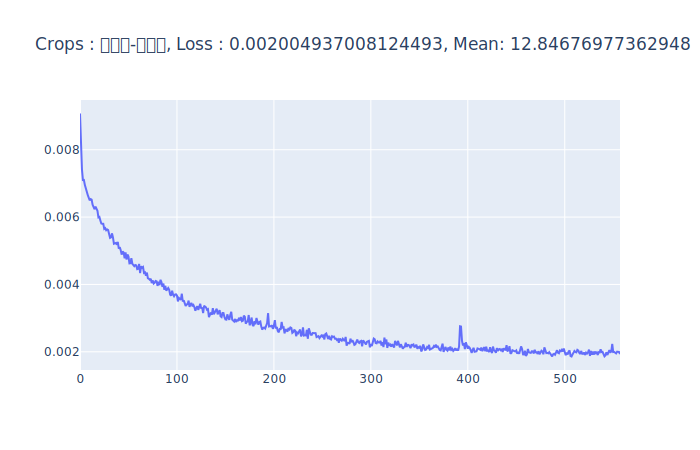

feature selection : Index(['3_day_return', 'Month', 'C0A530_Temperature', '467490_StnPres',
       '467420_StnPres', '467420_Precp', '467440_StnPres',
       '467440_Temperature', 'C0D560_StnPres', 'C0D560_Temperature',
       'C0E750_StnPres', 'C0E750_Temperature', 'C0H950_StnPres',
       'C0H950_Precp', 'C0G660_Temperature', 'C0G660_WS', 'C0G660_Precp',
       'C0K240_Precp', '467480_StnPres', '467480_Precp', '467590_StnPres',
       '467590_Temperature', '467590_WS', '467590_Precp', '467080_StnPres',
       '467660_StnPres', '467660_Temperature'],
      dtype='object')


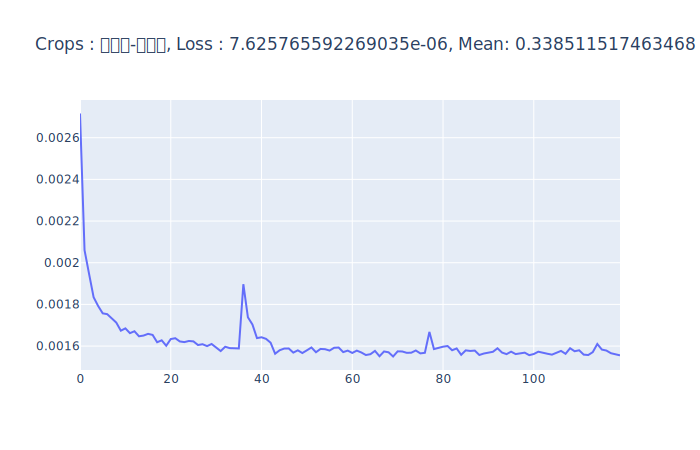

feature selection : Index(['3_day_return', 'Month', '平均價', '5_day_return', 'C0A530_StnPres',
       'C0A530_Precp', '467490_Temperature', '467420_StnPres',
       'C0C590_StnPres', 'C0C590_Temperature', 'C0D560_StnPres',
       'C0D560_Precp', 'C0E750_Temperature', 'C0E750_Precp', 'C0H950_StnPres',
       'C0H950_Temperature', 'C0H950_Precp', 'C0G660_Temperature',
       'C0K240_StnPres', 'C0K240_Precp', '467480_Precp', '467590_Temperature',
       '467590_Precp', '467080_StnPres', '467080_Precp', 'C0Z061_StnPres',
       'C0Z061_Temperature', 'C0Z061_Precp'],
      dtype='object')


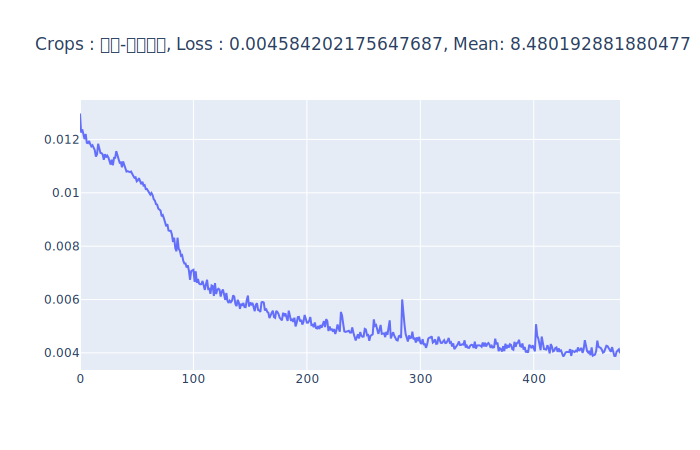

In [9]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    DateTime_arr = df["DateTime"][split_boundary:]
    df = df.drop(columns=["DateTime", "Year", "Day"])
    df = get_important_feature(df, split_boundary - 6, "3_day_return")
    print("feature selection :", df.columns)
    test_y_list, predict_y_list, loss, mean_diff = train(df, crops, split_boundary - 6, "3_day_return")
    data = {
        "DateTime": DateTime_arr,
        "Original": test_y_list,
        "Predict": predict_y_list,
        "Loss": loss,
        "Mean": mean_diff
    }
    df = pd.DataFrame(data)
    df.to_csv("{}_3_day_return_fs.csv".format(crops), index=False, encoding="utf_8_sig")

## Plot line chart

In [27]:
def plot_chart_all(crops):
    csv_arr = ["Price", "Price_fs", "1_day_return", "1_day_return_fs", "3_day_return", "3_day_return_fs"]
    fig = make_subplots(
        rows=6, cols=1,
        subplot_titles=csv_arr
    )
   
    for i in range(6):
        df = pd.read_csv("./{}_{}.csv".format(crops, csv_arr[i]))
        print("{}_{}, Loss : {}, Mean : {}".format(crops, csv_arr[i], df['Loss'][0], df['Mean'][0]))
        fig.add_trace(
            go.Scatter(
                x=df["DateTime"],
                y=df["Original"],
                mode="lines",
                name="Original return",
                line=dict(color="royalblue"),
            ),
            row=i + 1,
            col=1,
        )
        fig.add_trace(
            go.Scatter(
                x=df["DateTime"],
                y=df["Predict"],
                mode="lines",
                name="Predict return",
                line=dict(color="red"),
            ),
            row=i + 1,
            col=1,
        )
    fig.update_layout(height=2000, title_text=crops)
    fig.show()


香蕉_Price, Loss : 0.03584212123262182, Mean : 11.525368716645
香蕉_Price_fs, Loss : 0.01913502388696084, Mean : 9.389938922231412
香蕉_1_day_return, Loss : 0.028534132800373344, Mean : 6.9563922958792
香蕉_1_day_return_fs, Loss : 0.014677880099821947, Mean : 5.1151557567852475
香蕉_3_day_return, Loss : 0.004887275344826107, Mean : 5.283113327478634
香蕉_3_day_return_fs, Loss : 0.007689770771327575, Mean : 6.470045359172596


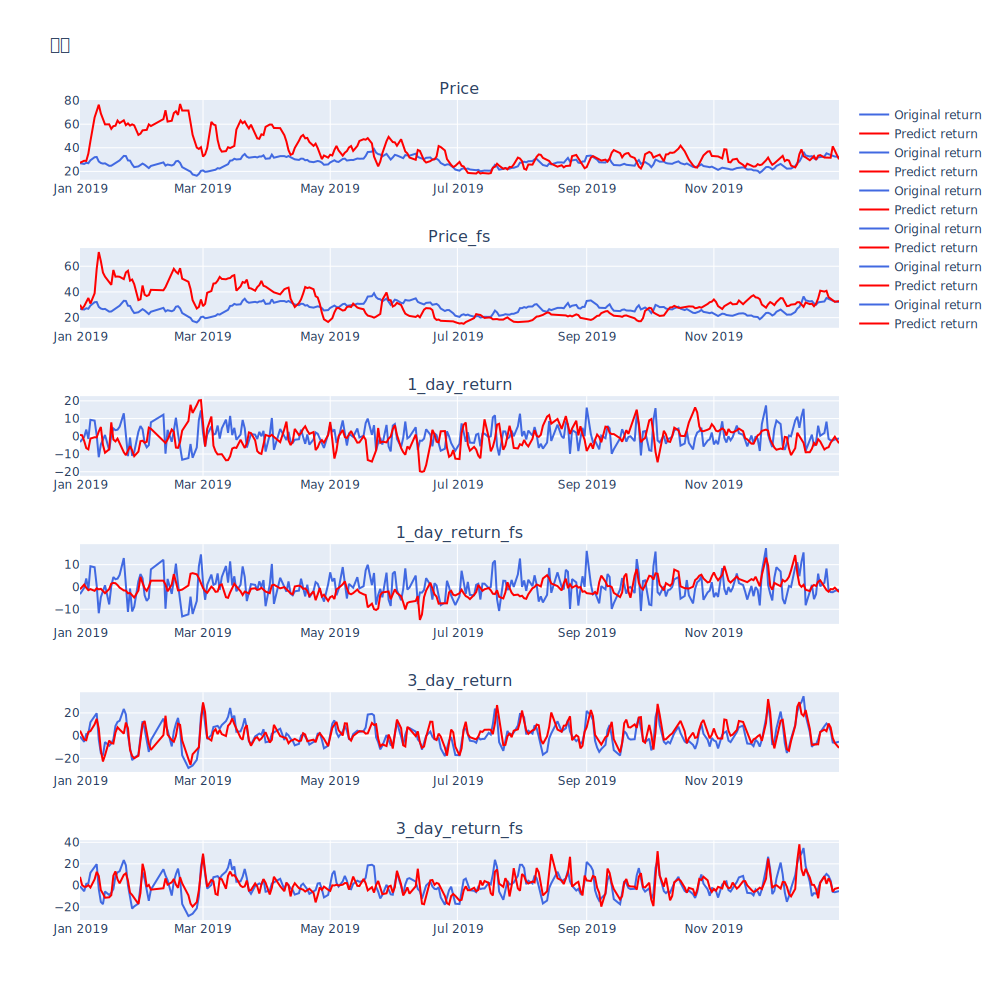

洋香瓜-網狀紅肉_Price, Loss : 0.004216849355685975, Mean : 8.092489574717826
洋香瓜-網狀紅肉_Price_fs, Loss : 0.004014681410171142, Mean : 7.9346693168692015
洋香瓜-網狀紅肉_1_day_return, Loss : 0.003184864880773714, Mean : 13.315564100042064
洋香瓜-網狀紅肉_1_day_return_fs, Loss : 0.0022916458978723157, Mean : 11.675841002017295
洋香瓜-網狀紅肉_3_day_return, Loss : 0.0009788668569538515, Mean : 14.593352089355646
洋香瓜-網狀紅肉_3_day_return_fs, Loss : 0.0014150114005374516, Mean : 17.587188190226232


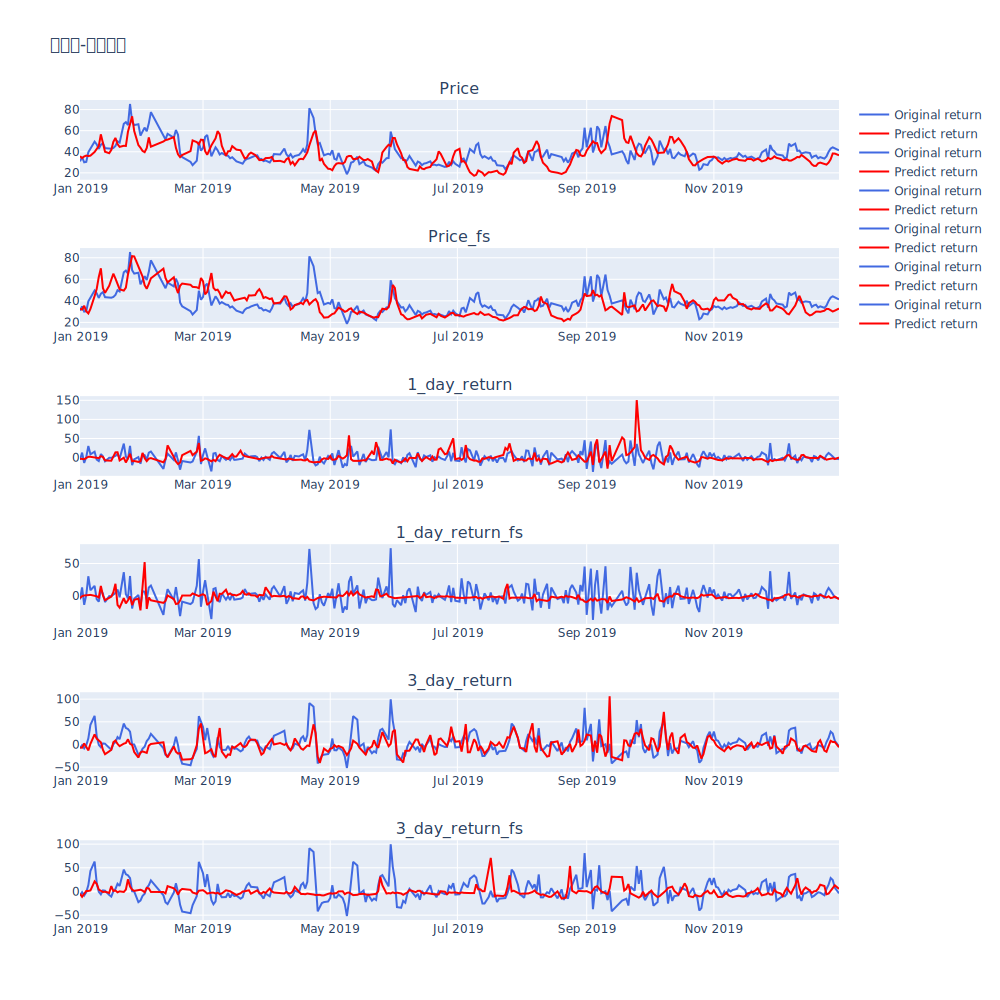

蓮霧-紅蓮霧_Price, Loss : 0.010095369059830005, Mean : 18.185606596773905
蓮霧-紅蓮霧_Price_fs, Loss : 0.033281363721080634, Mean : 30.08414940290003
蓮霧-紅蓮霧_1_day_return, Loss : 0.0018715925066225578, Mean : 10.791859162905359
蓮霧-紅蓮霧_1_day_return_fs, Loss : 0.0014223343288000895, Mean : 9.292240030021624
蓮霧-紅蓮霧_3_day_return, Loss : 0.003749677133215153, Mean : 11.312974325139908
蓮霧-紅蓮霧_3_day_return_fs, Loss : 0.0038238665020255843, Mean : 12.05308850493692


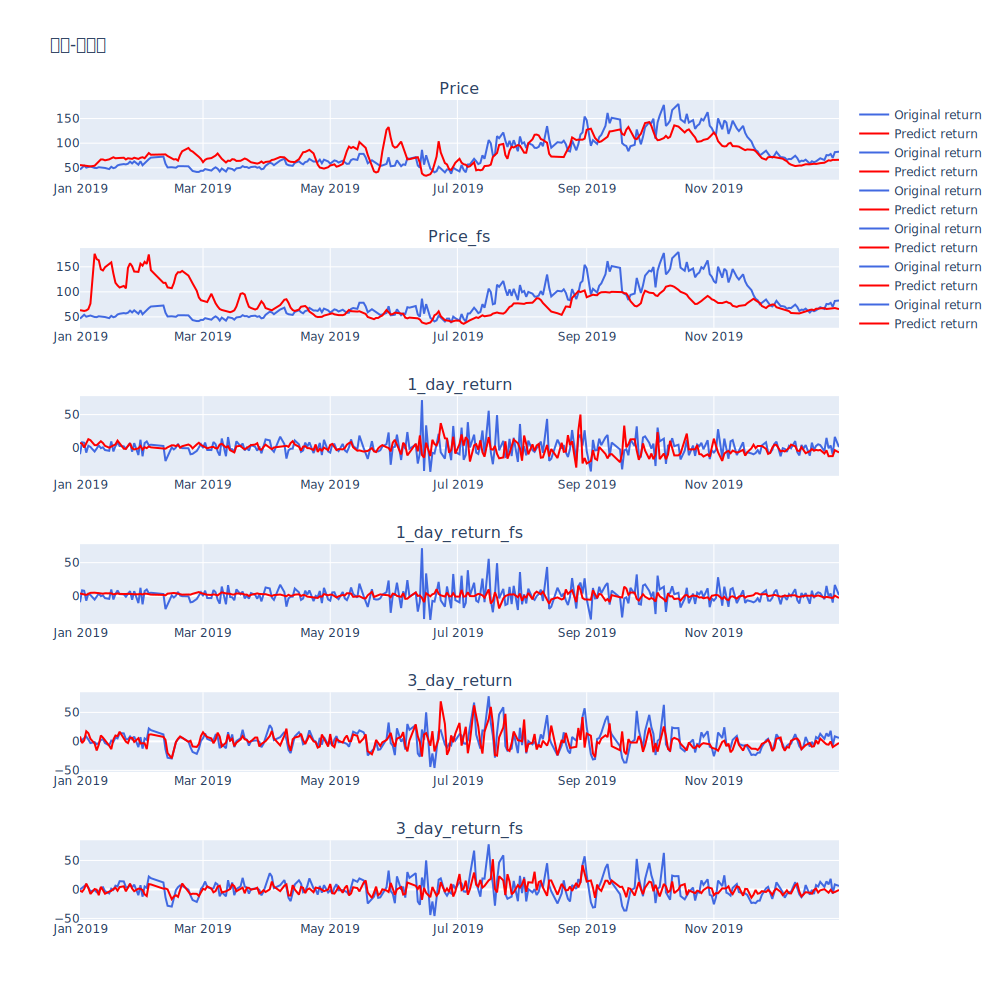

鳳梨-金鑽鳳梨_Price, Loss : 0.02001418459873933, Mean : 4.327160924573406
鳳梨-金鑽鳳梨_Price_fs, Loss : 0.0541799823227136, Mean : 7.765506320175119
鳳梨-金鑽鳳梨_1_day_return, Loss : 0.011265265777158895, Mean : 8.371745397708585
鳳梨-金鑽鳳梨_1_day_return_fs, Loss : 0.006679568229473654, Mean : 6.514849563706447
鳳梨-金鑽鳳梨_3_day_return, Loss : 0.006959470873542852, Mean : 6.901958650633844
鳳梨-金鑽鳳梨_3_day_return_fs, Loss : 0.03290888464645199, Mean : 15.745301909413335


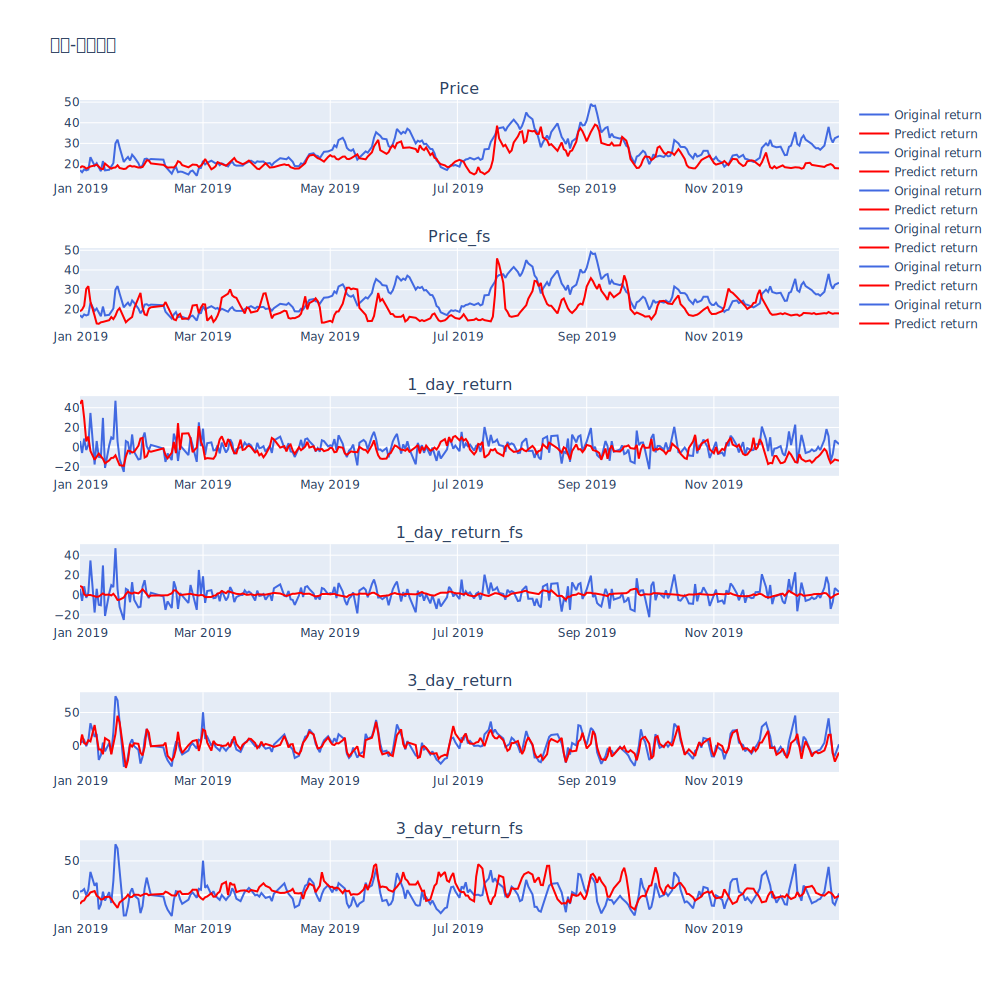

南瓜-木瓜形_Price, Loss : 0.02589081622734915, Mean : 6.397549750414183
南瓜-木瓜形_Price_fs, Loss : 0.019193076422705898, Mean : 5.6416868037603365
南瓜-木瓜形_1_day_return, Loss : 0.011654685016637387, Mean : 10.810025342727815
南瓜-木瓜形_1_day_return_fs, Loss : 0.003448305517025479, Mean : 7.081022168385341
南瓜-木瓜形_3_day_return, Loss : 0.002009253530182181, Mean : 7.944016558000765
南瓜-木瓜形_3_day_return_fs, Loss : 0.001898427390984811, Mean : 7.228191414211715


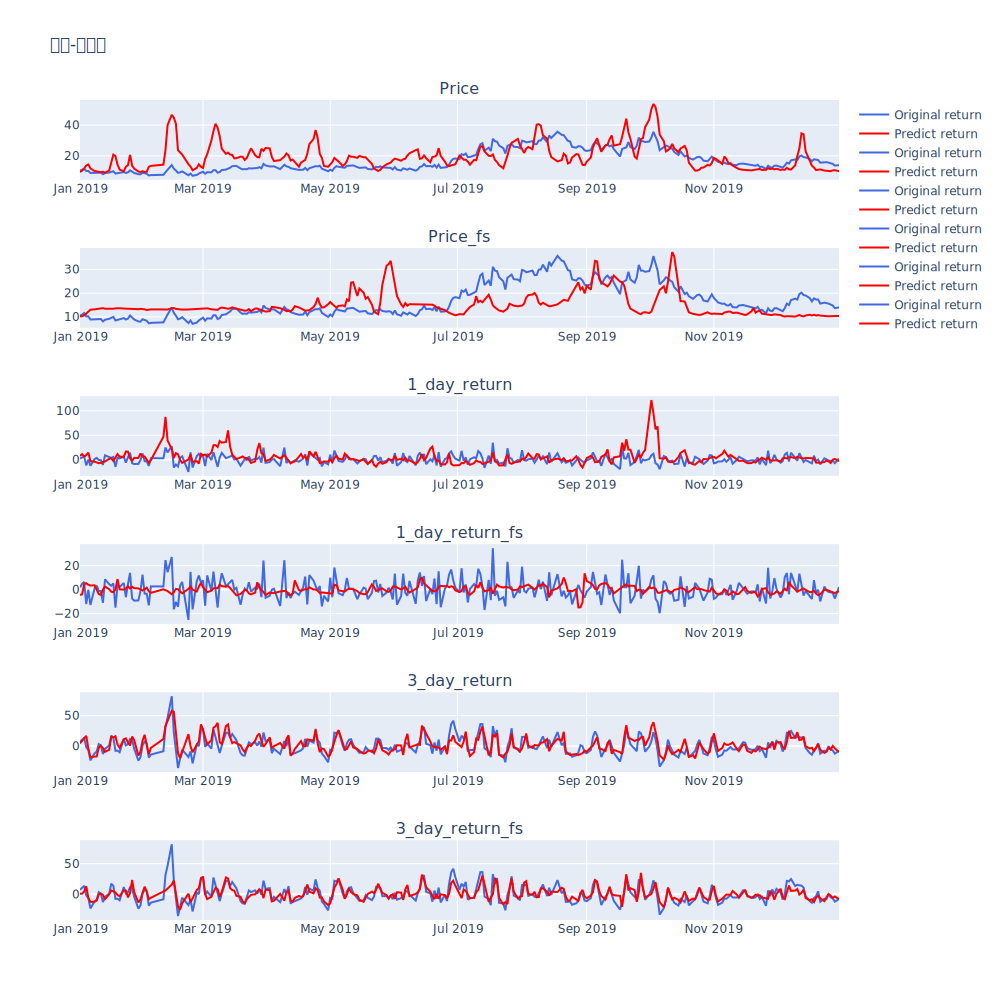

大蒜-蒜瓣_Price, Loss : 0.025007516793582752, Mean : 26.957936325838734
大蒜-蒜瓣_Price_fs, Loss : 0.034007693014814704, Mean : 32.81573096948324
大蒜-蒜瓣_1_day_return, Loss : 0.009268006300522531, Mean : 7.885959696663043
大蒜-蒜瓣_1_day_return_fs, Loss : 0.007487320764781441, Mean : 6.288632099122691
大蒜-蒜瓣_3_day_return, Loss : 0.007277062779485581, Mean : 7.0368976408981085
大蒜-蒜瓣_3_day_return_fs, Loss : 0.003900972257265478, Mean : 4.9452988898682975


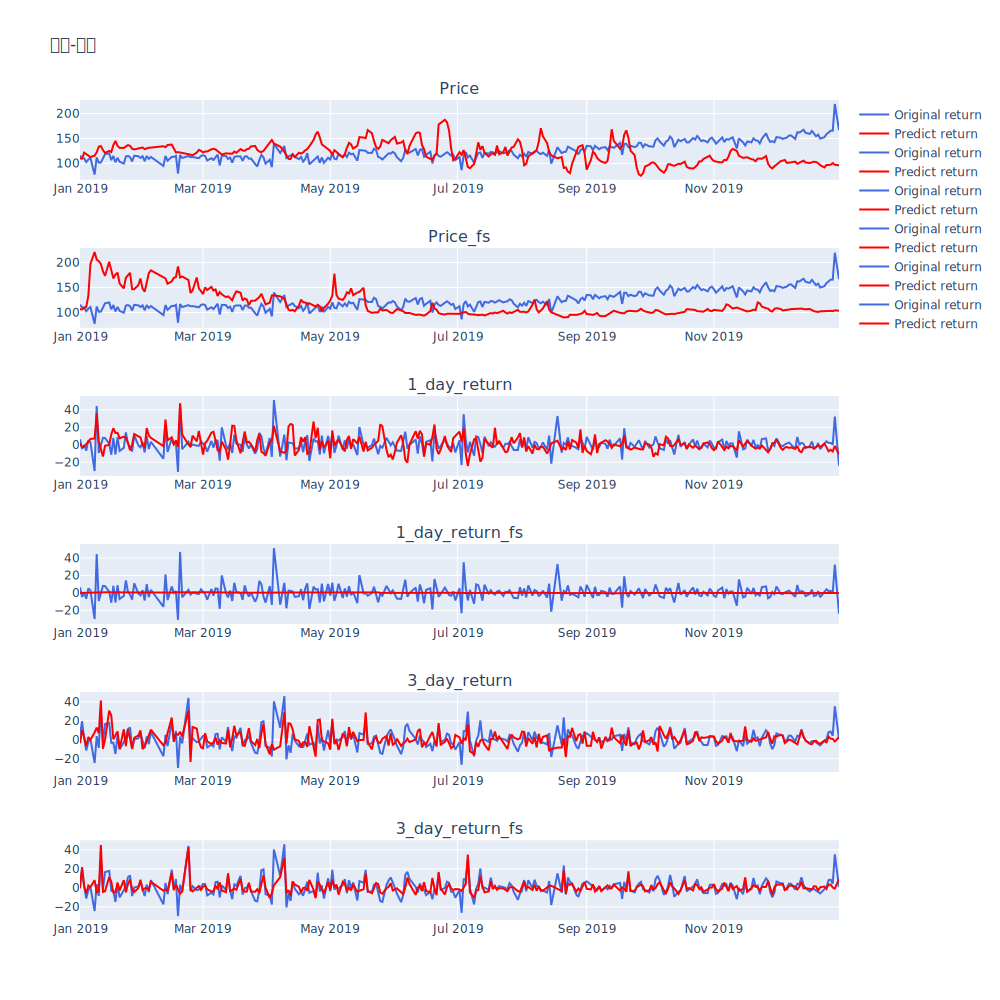

青蔥-日蔥_Price, Loss : 0.08654132621194606, Mean : 73.21610863216745
青蔥-日蔥_Price_fs, Loss : 0.08342456055126063, Mean : 72.69955487458601
青蔥-日蔥_1_day_return, Loss : 0.015009261580514268, Mean : 17.73017853994383
青蔥-日蔥_1_day_return_fs, Loss : 0.006091606862419425, Mean : 11.246486397061602
青蔥-日蔥_3_day_return, Loss : 0.003855650440710332, Mean : 11.648589420396693
青蔥-日蔥_3_day_return_fs, Loss : 0.0032376139788782487, Mean : 10.09877366043106


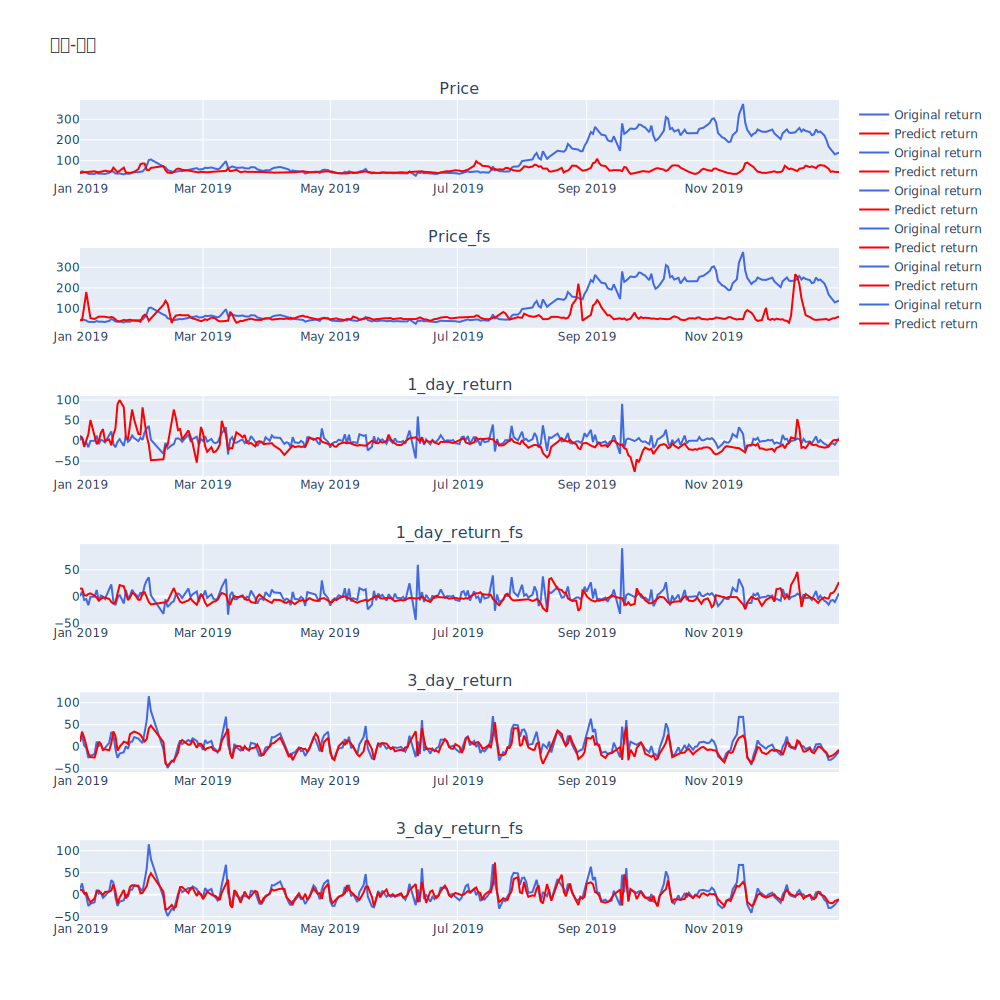

小白菜-土白菜_Price, Loss : 0.01923754372880062, Mean : 9.191745220937056
小白菜-土白菜_Price_fs, Loss : 0.03625034112997204, Mean : 12.532202580939964
小白菜-土白菜_1_day_return, Loss : 0.012011552916335122, Mean : 17.775727972378167
小白菜-土白菜_1_day_return_fs, Loss : 0.006402034062135304, Mean : 12.626172532712822
小白菜-土白菜_3_day_return, Loss : 0.0023056037634857198, Mean : 13.554800351462625
小白菜-土白菜_3_day_return_fs, Loss : 0.002004937008124493, Mean : 12.846769773629479


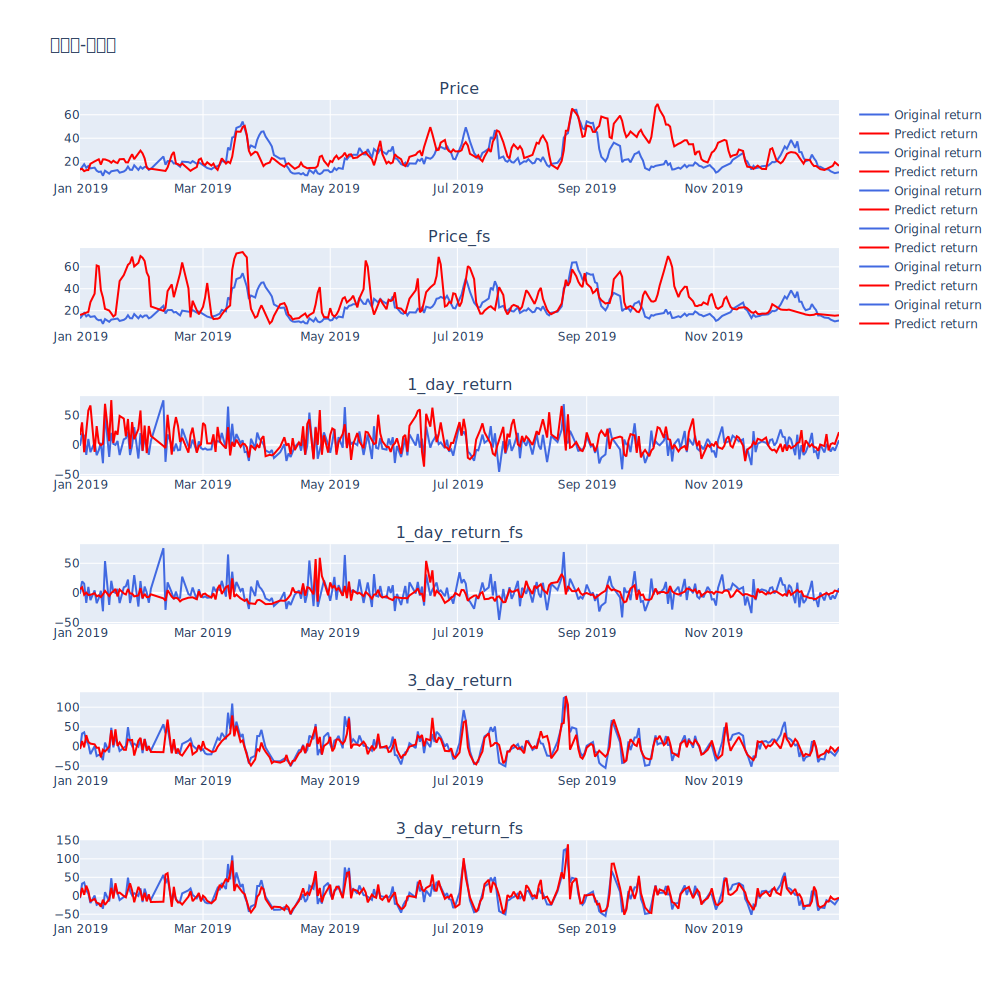

芽菜類-黃豆牙_Price, Loss : 0.00013886510104651215, Mean : 0.3607259140271541
芽菜類-黃豆牙_Price_fs, Loss : 0.0001422084895588194, Mean : 0.34725238016558824
芽菜類-黃豆牙_1_day_return, Loss : 1.6498646145429378e-05, Mean : 0.6151072076444929
芽菜類-黃豆牙_1_day_return_fs, Loss : 9.849477124828467e-06, Mean : 0.3266835744634029
芽菜類-黃豆牙_3_day_return, Loss : 6.377383492736504e-05, Mean : 1.2401812607127158
芽菜類-黃豆牙_3_day_return_fs, Loss : 7.625765592269035e-06, Mean : 0.338511517463468


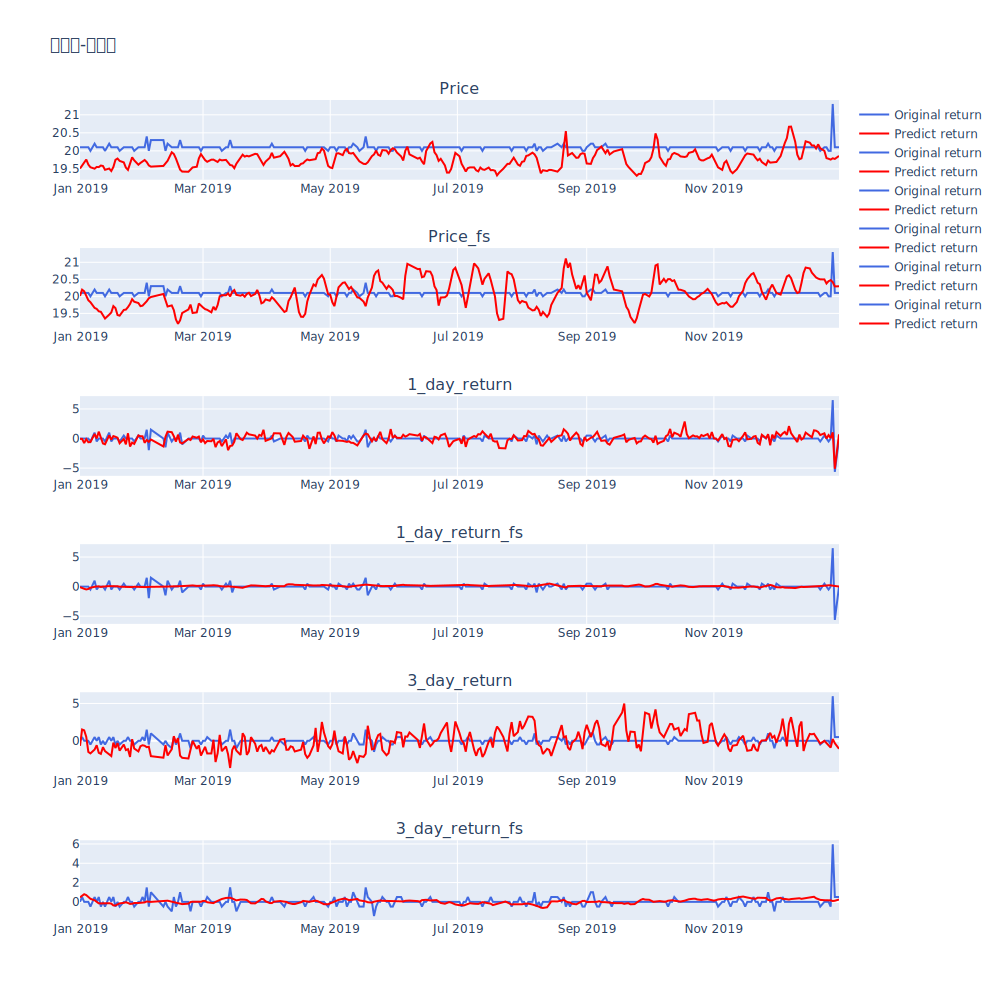

木瓜-網室紅肉_Price, Loss : 0.013657822133506022, Mean : 7.465892692234206
木瓜-網室紅肉_Price_fs, Loss : 0.02028051757231903, Mean : 9.655358664726334
木瓜-網室紅肉_1_day_return, Loss : 0.019905347582638063, Mean : 12.9320077349327
木瓜-網室紅肉_1_day_return_fs, Loss : 0.01100175430683612, Mean : 9.054851365865414
木瓜-網室紅肉_3_day_return, Loss : 0.004249262684422006, Mean : 8.3327504479455
木瓜-網室紅肉_3_day_return_fs, Loss : 0.004584202175647686, Mean : 8.480192881880477


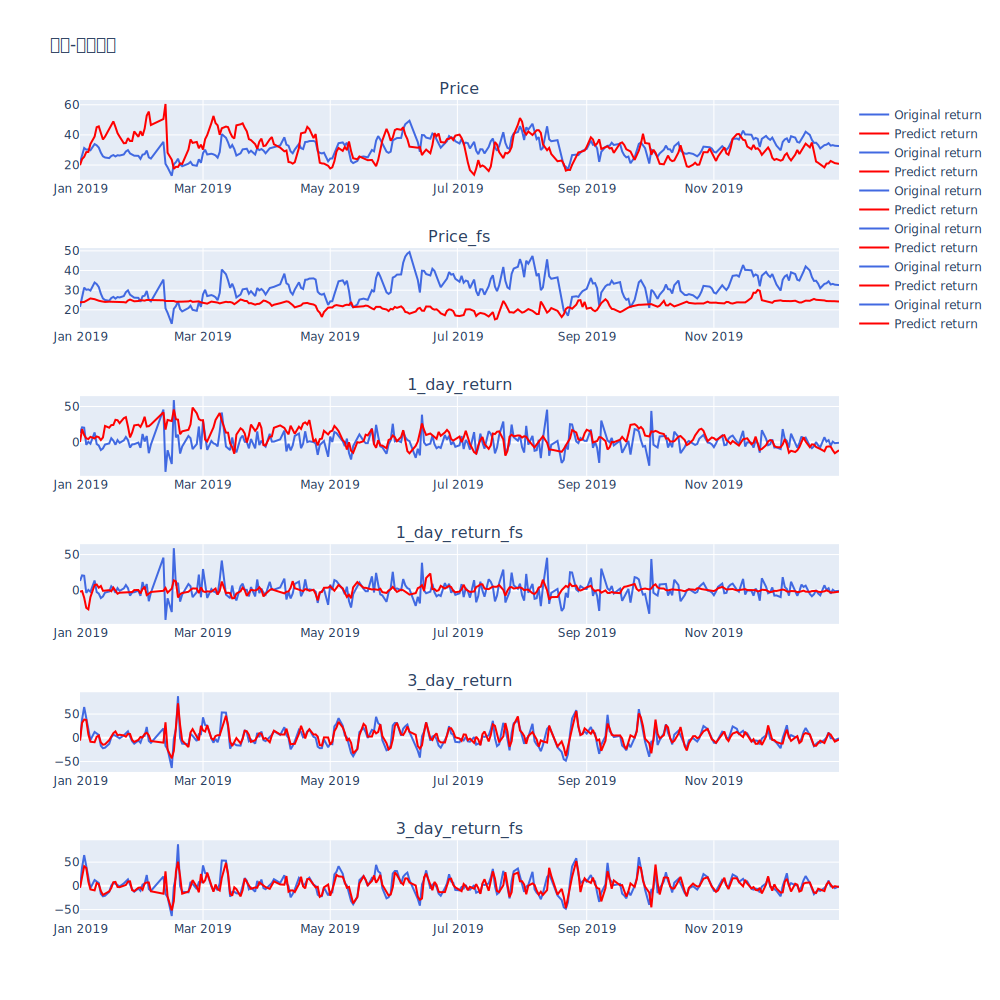

In [28]:
for crops in crops_arr:
    plot_chart_all(crops)